# **Unsupervised Learning Project - Trade&Ahead**

* Student: Alexey Tyurin
* Group: Oct'22 C Sun - MLS Grp B
* Batch: PGP-DSBA-UTA-OCT22-C
* Date: 5/19/2023 - 5/25/2023

## Problem Statement

### Context

The stock market has consistently proven to be a good place to invest in and save for the future. There are a lot of compelling reasons to invest in stocks. It can help in fighting inflation, create wealth, and also provides some tax benefits. Good steady returns on investments over a long period of time can also grow a lot more than seems possible. Also, thanks to the power of compound interest, the earlier one starts investing, the larger the corpus one can have for retirement. Overall, investing in stocks can help meet life's financial aspirations.

It is important to maintain a diversified portfolio when investing in stocks in order to maximise earnings under any market condition. Having a diversified portfolio tends to yield higher returns and face lower risk by tempering potential losses when the market is down. It is often easy to get lost in a sea of financial metrics to analyze while determining the worth of a stock, and doing the same for a multitude of stocks to identify the right picks for an individual can be a tedious task. By doing a cluster analysis, one can identify stocks that exhibit similar characteristics and ones which exhibit minimum correlation. This will help investors better analyze stocks across different market segments and help protect against risks that could make the portfolio vulnerable to losses.


### Objective

Trade&Ahead is a financial consultancy firm who provide their customers with personalized investment strategies. They have hired you as a Data Scientist and provided you with data comprising stock price and some financial indicators for a few companies listed under the New York Stock Exchange. They have assigned you the tasks of analyzing the data, grouping the stocks based on the attributes provided, and sharing insights about the characteristics of each group.

### Data Dictionary

- `Ticker Symbol`: An abbreviation used to uniquely identify publicly traded shares of a particular stock on a particular stock market
- `Security`: Name of the company
- `GICS Sector`: The specific economic sector assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- `GICS Sub Industry`: The specific sub-industry group assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- `Current Price`: Current stock price in dollars
- `Price Change`: Percentage change in the stock price in 13 weeks
- `Volatility`: Standard deviation of the stock price over the past 13 weeks
- `ROE`: A measure of financial performance calculated by dividing net income by shareholders' equity (shareholders' equity is equal to a company's assets minus its debt)
- `Cash Ratio`: The ratio of a  company's total reserves of cash and cash equivalents to its total current liabilities
- `Net Cash Flow`: The difference between a company's cash inflows and outflows (in dollars)
- `Net Income`: Revenues minus expenses, interest, and taxes (in dollars)
- `Earnings Per Share`: Company's net profit divided by the number of common shares it has outstanding (in dollars)
- `Estimated Shares Outstanding`: Company's stock currently held by all its shareholders
- `P/E Ratio`: Ratio of the company's current stock price to the earnings per share 
- `P/B Ratio`: Ratio of the company's stock price per share by its book value per share (book value of a company is the net difference between that company's total assets and total liabilities)

## Importing necessary libraries and data

In [1]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# to perform PCA
from sklearn.decomposition import PCA

# to perform t-SNE
from sklearn.manifold import TSNE

## Loading the dataset

In [2]:
## Complete the code to import the data
data = pd.read_csv('stock_data.csv')

## User-defined functions

### Combined boxplot and histogram

In [3]:
# functiom to create combined boxplot and histogram
def histogram_boxplot(data, feature, figsize=(10, 5), fmt='{:.1f}', rotation=0,
                      title=None, kde=True, bins=None, step=None, xlabel=None):
    x = data[feature]
    colors = sns.color_palette("Spectral")
    title = title if title else f'Distribution for `{feature}` column'

    x_min, x_max = x.min(), x.max()

    if (bins == None) & (step == None):
        bins = int(3 * np.log(x.nunique())) + 2
    elif bins == None:
        x_min = step * round(x_min / step, 0)
        x_max = step * round(x_max / step, 0) + step
        bins = int((x_max - x_min) / step)

    bw = (x_max - x_min) / bins

    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=figsize,
                           gridspec_kw={"height_ratios": (0.3, 0.7)})

    plt.suptitle(title, fontsize=16)
    box = sns.boxplot(data=data, x=feature, ax=ax[0], showmeans=True, color=colors[1])
    hist = sns.histplot(data=data, x=feature, kde=kde, ax=ax[1], color=colors[4], bins=bins)

    ax[0].set_xlabel('')
    ax[1].axvline(x.median(), color="grey", linestyle="-")
    ax[1].axvline(x.mean(), color="darkgreen", linestyle="--")
    ax[1].set_ylabel('Number of observations', fontsize=12)
    if xlabel: ax[1].set_xlabel(xlabel, fontsize=12)

    labels = [fmt.format(x) for x in np.arange(x_min, x_max, bw)]
    ticks =  [x+bw/2 for x in np.arange(x_min, x_max, bw)]

    ax[1].set_xticks(ticks)
    ax[1].set_xticklabels(labels, rotation=rotation)

    plt.show();

### Labeled countplots

In [4]:
# function to create labeled barplots
def labled_countplot(data, feature, perc=False, n=None, percfmt="{:.1f}%", rnd=0,
                    figsize=(10, 5), xlabel=None, xlo=0, title=None, sort=True, 
                    orient='h', ylabel=None):
    """
    Barplot with percentage at the top

    data: dataframe
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    figsize: size of figure (default (10, 5))
    xlabel: label for x axis
    ylabel: label for y axis
    """

    fig, ax = plt.subplots(figsize=figsize)
    plt.xticks(rotation=xlo, fontsize=14)
    if orient == 'h':
      sns.countplot(data=data, x=feature, palette="Paired",
                    order=data[feature].value_counts().index[:n] if sort else None)
    else:
      sns.countplot(data=data, y=feature, palette="Paired",
                    order=data[feature].value_counts().index[:n] if sort else None)

    # draw lables
    for p in ax.patches:
      if orient == 'h':
        if perc == True:
          label = percfmt.format(100 * p.get_height() / data.shape[0])
        else:
          label = p.get_height()
        ax.annotate(label, (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha="center", va="center", size=11, xytext=(0, 5),
                    textcoords="offset points")
        ax.set_ylabel(ylabel, fontsize=14)
        if xlabel: ax.set_xlabel(xlabel, fontsize=14)
      else:
        if perc == True:
          label = percfmt.format(100 * p.get_width() / data.shape[0])
        else:
          label = p.get_width()
        ax.annotate(label, (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha="center", va="center", size=11, xytext=(20, 0),
                    textcoords="offset points")
        ax.set_xlabel(ylabel, fontsize=14)
        if xlabel: ax.set_ylabel(xlabel, fontsize=14)

    if title: plt.title(title, fontsize=16)
    else: plt.title(f'Distribution for `{feature}` column', fontsize=16)

    plt.show()

### Labeled barplots

In [5]:
# function to create labeled barplots
def labled_barplot(data, feature, n=None, fmt="{:.1f}%", rnd=0, ylabel=None,
                    figsize=(10, 5), xlabel=None, xlo=0, title=None, sort=True, 
                    orient='h', groupby=None):

    fig, ax = plt.subplots(figsize=figsize)
    plt.xticks(rotation=xlo, fontsize=14)
    if orient == 'h':
      sns.barplot(data=data, x=groupby, y=feature, palette="RdBu", errorbar=None,
                    order=data.groupby(groupby).mean()[feature].sort_values(ascending=False).index[:n] if sort else None)
    else:
      sns.barplot(data=data, y=groupby, x=feature, palette="RdBu", errorbar=None,
                    order=data.groupby(groupby).mean()[feature].sort_values(ascending=False).index[:n] if sort else None)

    # draw lables
    for p in ax.patches:
      if orient == 'h':
        if fmt:
          label = fmt.format(p.get_height())
        ax.annotate(label, (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha="center", va="center", size=11, xytext=(0, 5),
                    textcoords="offset points")
        ax.set_ylabel(ylabel, fontsize=14)
        if xlabel: ax.set_xlabel(xlabel, fontsize=14)
      else:
        if fmt:
          label = fmt.format(p.get_width())
        ax.annotate(label, (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha="center", va="center", size=11, xytext=(20, 0),
                    textcoords="offset points")
        ax.set_xlabel(ylabel, fontsize=14)
        if xlabel: ax.set_ylabel(xlabel, fontsize=14)

    if title: plt.title(title, fontsize=16)
    else: plt.title(f'Distribution for `{feature}` column', fontsize=16)

    plt.show()

## Data Overview

Steps to get an overview of the dataset are:

- observe the first few rows of the dataset, to check whether the dataset has been loaded properly or not
- get information about the number of rows and columns in the dataset
- find out the data types of the columns to ensure that data is stored in the preferred format and the value of each property is as expected
- check the statistical summary of the dataset to get an overview of the numerical columns of the data.<br><br>
- [x] Observations
- [x] Sanity checks


### Checking the shape of the dataset

In [6]:
# checking shape of the data
print(f'There are {data.shape[0]} rows and {data.shape[1]} columns.')

There are 340 rows and 15 columns.


### View the first and last 5 rows of the dataset

In [7]:
data.head()

Ticker Symbol                 Security             GICS Sector  \
0           AAL  American Airlines Group             Industrials   
1          ABBV                   AbbVie             Health Care   
2           ABT      Abbott Laboratories             Health Care   
3          ADBE        Adobe Systems Inc  Information Technology   
4           ADI     Analog Devices, Inc.  Information Technology   

       GICS Sub Industry  Current Price  Price Change  Volatility  ROE  \
0               Airlines      42.349998      9.999995    1.687151  135   
1        Pharmaceuticals      59.240002      8.339433    2.197887  130   
2  Health Care Equipment      44.910000     11.301121    1.273646   21   
3   Application Software      93.940002     13.977195    1.357679    9   
4         Semiconductors      55.320000     -1.827858    1.701169   14   

   Cash Ratio  Net Cash Flow  Net Income  Earnings Per Share  \
0          51     -604000000  7610000000               11.39   
1          77       51000000  5144000000                3.15   
2          67      938000000  4423000000                2.94   
3         180     -240840000   629551000                1.26   
4         272      315120000   696878000                0.31   

   Estimated Shares Outstanding   P/E Ratio  P/B Ratio  
0                  6.681299e+08    3.718174  -8.784219  
1                  1.633016e+09   18.806350  -8.750068  
2                  1.504422e+09   15.275510  -0.394171  
3                  4.996437e+08   74.555557   4.199651  
4                  2.247994e+09  178.451613   1.059810

In [8]:
data.tail()

Ticker Symbol                Security             GICS Sector  \
335          YHOO              Yahoo Inc.  Information Technology   
336           YUM         Yum! Brands Inc  Consumer Discretionary   
337           ZBH  Zimmer Biomet Holdings             Health Care   
338          ZION           Zions Bancorp              Financials   
339           ZTS                  Zoetis             Health Care   

                GICS Sub Industry  Current Price  Price Change  Volatility  \
335  Internet Software & Services      33.259998     14.887727    1.845149   
336                   Restaurants      52.516175     -8.698917    1.478877   
337         Health Care Equipment     102.589996      9.347683    1.404206   
338                Regional Banks      27.299999     -1.158588    1.468176   
339               Pharmaceuticals      47.919998     16.678836    1.610285   

     ROE  Cash Ratio  Net Cash Flow  Net Income  Earnings Per Share  \
335   15         459    -1032187000 -4359082000               -4.64   
336  142          27      159000000  1293000000                2.97   
337    1         100      376000000   147000000                0.78   
338    4          99      -43623000   309471000                1.20   
339   32          65      272000000   339000000                0.68   

     Estimated Shares Outstanding   P/E Ratio  P/B Ratio  
335                   939457327.6   28.976191   6.261775  
336                   435353535.4   17.682214  -3.838260  
337                   188461538.5  131.525636 -23.884449  
338                   257892500.0   22.749999  -0.063096  
339                   498529411.8   70.470585   1.723068

### Displaying few rows of the dataset

In [9]:
# let's view a sample of the data
data.sample(n=10, random_state=1)

Ticker Symbol                     Security             GICS Sector  \
102           DVN           Devon Energy Corp.                  Energy   
125            FB                     Facebook  Information Technology   
11            AIV  Apartment Investment & Mgmt             Real Estate   
248            PG             Procter & Gamble        Consumer Staples   
238           OXY         Occidental Petroleum                  Energy   
336           YUM              Yum! Brands Inc  Consumer Discretionary   
112           EQT              EQT Corporation                  Energy   
147           HAL              Halliburton Co.                  Energy   
89            DFS  Discover Financial Services              Financials   
173           IVZ                 Invesco Ltd.              Financials   

                      GICS Sub Industry  Current Price  Price Change  \
102  Oil & Gas Exploration & Production      32.000000    -15.478079   
125        Internet Software & Services     104.660004     16.224320   
11                                REITs      40.029999      7.578608   
248                   Personal Products      79.410004     10.660538   
238  Oil & Gas Exploration & Production      67.610001      0.865287   
336                         Restaurants      52.516175     -8.698917   
112  Oil & Gas Exploration & Production      52.130001    -21.253771   
147      Oil & Gas Equipment & Services      34.040001     -5.101751   
89                     Consumer Finance      53.619999      3.653584   
173    Asset Management & Custody Banks      33.480000      7.067477   

     Volatility  ROE  Cash Ratio  Net Cash Flow   Net Income  \
102    2.923698  205          70      830000000 -14454000000   
125    1.320606    8         958      592000000   3669000000   
11     1.163334   15          47       21818000    248710000   
248    0.806056   17         129      160383000    636056000   
238    1.589520   32          64     -588000000  -7829000000   
336    1.478877  142          27      159000000   1293000000   
112    2.364883    2         201      523803000     85171000   
147    1.966062    4         189     7786000000   -671000000   
89     1.159897   20          99     2288000000   2297000000   
173    1.580839   12          67      412000000    968100000   

     Earnings Per Share  Estimated Shares Outstanding  P/E Ratio  P/B Ratio  
102              -35.55                  4.065823e+08  93.089287   1.785616  
125                1.31                  2.800763e+09  79.893133   5.884467  
11                 1.52                  1.636250e+08  26.335526  -1.269332  
248                3.28                  4.913916e+08  24.070121  -2.256747  
238              -10.23                  7.652981e+08  93.089287   3.345102  
336                2.97                  4.353535e+08  17.682214  -3.838260  
112                0.56                  1.520911e+08  93.089287   9.567952  
147               -0.79                  8.493671e+08  93.089287  17.345857  
89                 5.14                  4.468872e+08  10.431906  -0.375934  
173                2.26                  4.283628e+08  14.814159   4.218620

### Checking the data types of the columns for the dataset

In [10]:
# checking the column names and datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticker Symbol                 340 non-null    object 
 1   Security                      340 non-null    object 
 2   GICS Sector                   340 non-null    object 
 3   GICS Sub Industry             340 non-null    object 
 4   Current Price                 340 non-null    float64
 5   Price Change                  340 non-null    float64
 6   Volatility                    340 non-null    float64
 7   ROE                           340 non-null    int64  
 8   Cash Ratio                    340 non-null    int64  
 9   Net Cash Flow                 340 non-null    int64  
 10  Net Income                    340 non-null    int64  
 11  Earnings Per Share            340 non-null    float64
 12  Estimated Shares Outstanding  340 non-null    float64
 13  P/E R

**Observations**:

- There are 11 numeric columns (7 float and 4 int) and 4 text columns (object) in the dataset


### Creating a copy of original data

In [11]:
# copying the data to another variable to avoid any changes to original data
df = data.copy()

### Checking for duplicates and missing values

In [12]:
# checking for duplicate values
df.duplicated().sum()

0

* There are no duplicate values in the dataset

In [13]:
# checking for missing values in the data
df.isna().sum()

Ticker Symbol                   0
Security                        0
GICS Sector                     0
GICS Sub Industry               0
Current Price                   0
Price Change                    0
Volatility                      0
ROE                             0
Cash Ratio                      0
Net Cash Flow                   0
Net Income                      0
Earnings Per Share              0
Estimated Shares Outstanding    0
P/E Ratio                       0
P/B Ratio                       0
dtype: int64

In [14]:
df.isna().sum().sum()

0

* There are no null values in the dataset

### Statistical summary of the dataset

**Let's check the statistical summary of the data.**

In [15]:
df.describe().T.style.format('{:,.2f}')

In [16]:
df.describe(include='object').T

count unique                                 top freq
Ticker Symbol       340    340                                 AAL    1
Security            340    340             American Airlines Group    1
GICS Sector         340     11                         Industrials   53
GICS Sub Industry   340    104  Oil & Gas Exploration & Production   16

**Observations:**

- `Ticker Symbol`: There are 340 unique ticker symbols in the dataset.
- `Security`: There are 340 unique securities in the dataset.
- `GICS Sector`: There are 11 unique GICS sectors in the dataset. The most common sector is "Industrials," which appears 53 times.
- `GICS Sub Industry`: There are 104 unique GICS sub-industries in the dataset. The most common sub-industry is `Oil & Gas Exploration & Production`, which appears 16 times.

- `Current Price`: The average current price is \$80.86, with a standard deviation of \$98.06. The minimum price is \$4.50, while the maximum price is \$1,274.95. The median is \$59.70. When the mean is higher than the median in a dataset, it indicates that the data is skewed to the right (or positively skewed). This situation often arises when there are a few high values in the dataset that pull the mean upwards, but do not affect the median as much.
- `Price Change`: The average price change (percentage change in the stock price in 13 weeks) is 4.08%, with a standard deviation of 12.01%. The largest decrease in price is 47.13%, while the largest increase is 55.05%.
- `Volatility`: The average volatility (standard deviation of the stock price over the past 13 weeks) is \$1.53. The minimum volatility is \$0.73, while the maximum is \$4.58, median is \$1.39.
- `Return on Equity (ROE)`: The median `ROE` is 15%, average is 39.60%,  with a standard deviation of 96.55%. The minimum ROE is 1%, while the maximum is 917%. The data is skewed to the right.
  * *A higher ROE means that a company is using its equity efficiently to generate profits. A lower ROE may indicate the opposite, although it's also important to compare a company's ROE to its industry peers and over time to get a true picture of performance.*
- `Cash Ratio`: The average cash ratio is 70.02%, with a standard deviation of 90.42%. The minimum cash ratio is 0%, while the maximum is 958%, the median is 47%. 
  * *A high cash ratio (around 100% or more) shows a company's strong short-term financial health, but may also hint at inefficient resource usage for growth. A low cash ratio (well below 100%) suggests possible liquidity risk, though it doesn't necessarily signal danger as the company may have other quick-turnaround resources.*
- `Net Cash Flow`: The average net cash flow is \$55.54M, with a standard deviation of \$1.95B. The largest negative cash flow is -\$11.21B, while the largest positive cash flow is \$20.76B. The median is \$2.1M.
- `Net Income`: The average net income is \$1.49B, with a standard deviation of \$3.94B. The largest loss in net income is -\$23.53B, while the largest gain is \$24.44B. The median is \$707.34M.
- `Earnings Per Share (EPS)`: The average EPS is \$2.78, with a standard deviation of \$6.59. The lowest EPS is -\$61.20, while the highest is \$50.09. The median is 2.90.
- `Estimated Shares Outstanding`: The average estimated shares outstanding is \$577M, with a standard deviation of \$845M. The lowest estimated shares outstanding is \$28M, while the highest is \$6.16B.
- `P/E Ratio`: The average P/E ratio is 32.61, with a standard deviation of 44.35. The lowest P/E ratio is 2.94, while the highest is 528.04.
  * *High P/E ratio could mean that the stock's price is high relative to earnings and possibly overvalued. Conversely, a low P/E ratio might indicate that the stock's price is low relative to earnings and possibly undervalued.*
  * *High P/E ratios can sometimes be justified by high growth rates. If a company's earnings are expected to grow quickly in the future, investors might be willing to pay more for the stock, leading to a higher P/E ratio.*
- `P/B Ratio`: The average P/B ratio is -1.72, with a standard deviation of 13.97. The lowest P/B ratio is -76.12, while the highest is 129.06. The median is -1.07.
  * *Similar to the P/E ratio, the P/B ratio indicates how much investors are willing to pay for each dollar of a company's net assets. A lower P/B ratio could mean that the stock is undervalued. Conversely, a higher P/B ratio could mean that the stock is overvalued.*

  * *The P/B ratio gives an indication of whether the company's assets are performing well or poorly. If a company's P/B ratio is below 1, it may suggest that the market believes the assets are worth less than their book value, possibly because they are not generating sufficient return.*

  * *The P/B ratio can be used to compare companies within the same industry. However, it is more useful in industries that rely heavily on tangible assets, such as manufacturing or utilities, as opposed to service or technology industries.*

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- Below are a few questions that will guide our analysis and enable us to generate insights from the data.
- In addition to the questions mentioned below, we will conduct a comprehensive analysis of the data to extract meaningful insights.

### Univariate analysis

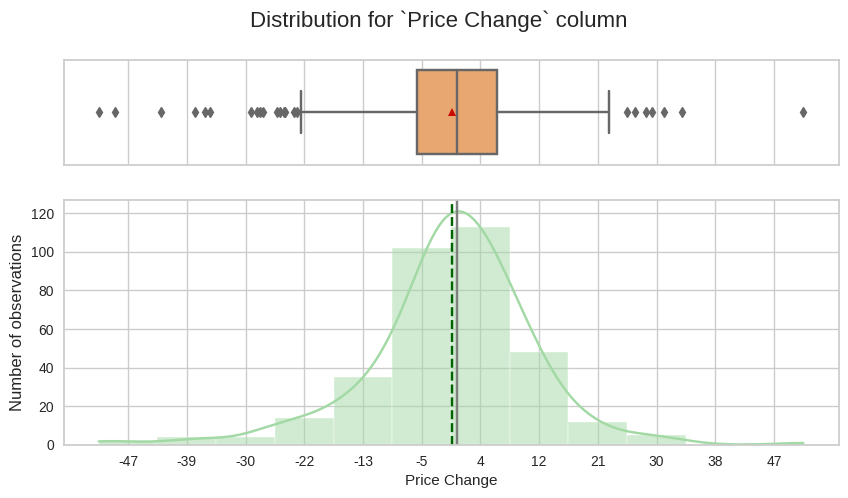

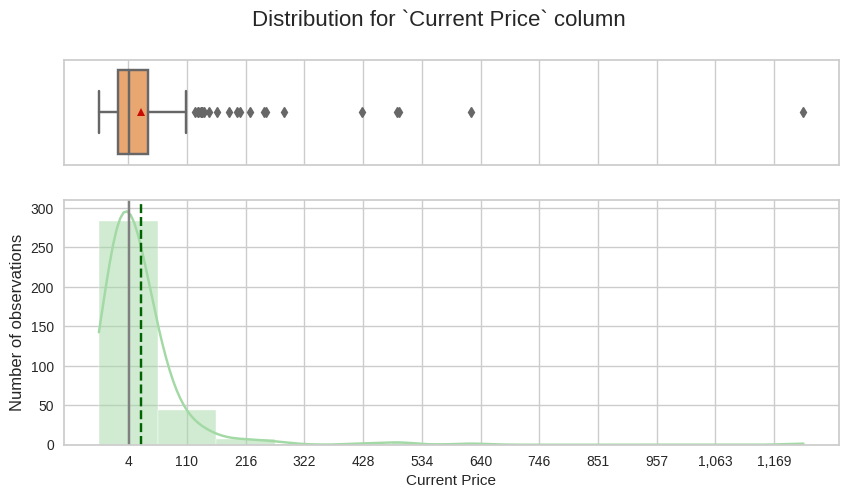

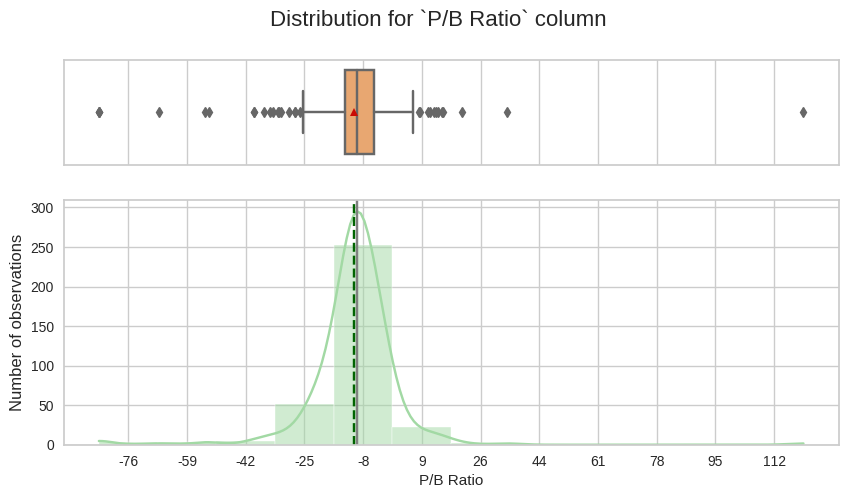

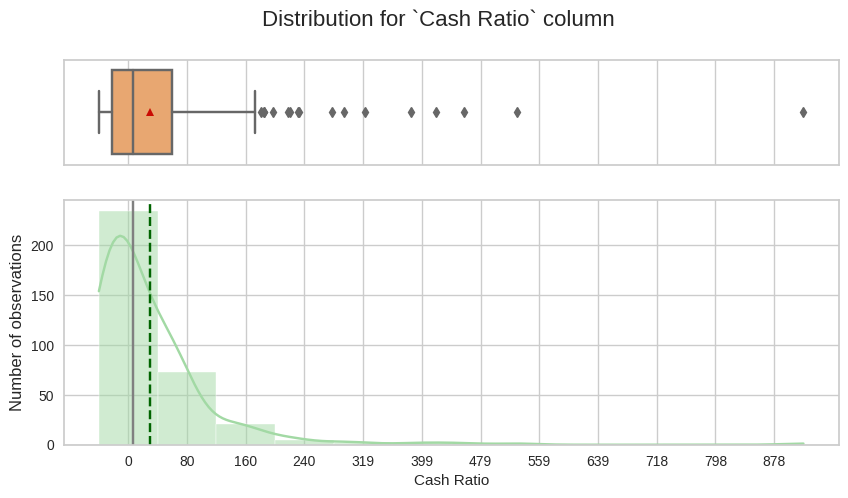

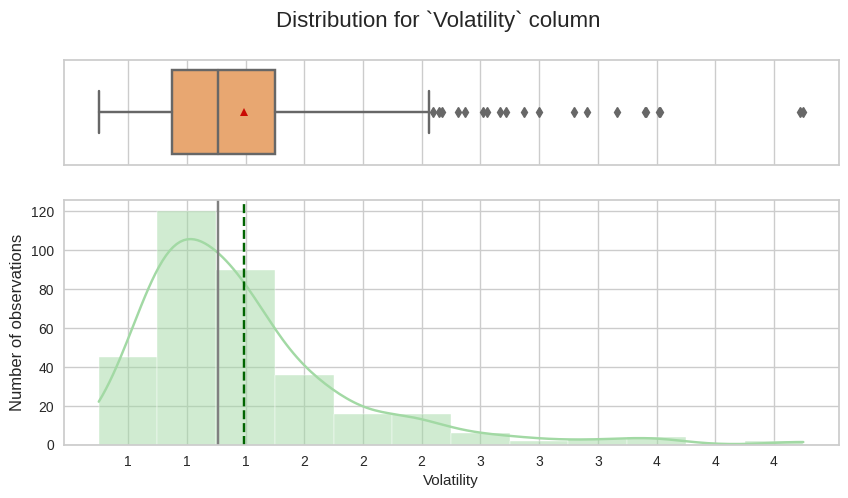

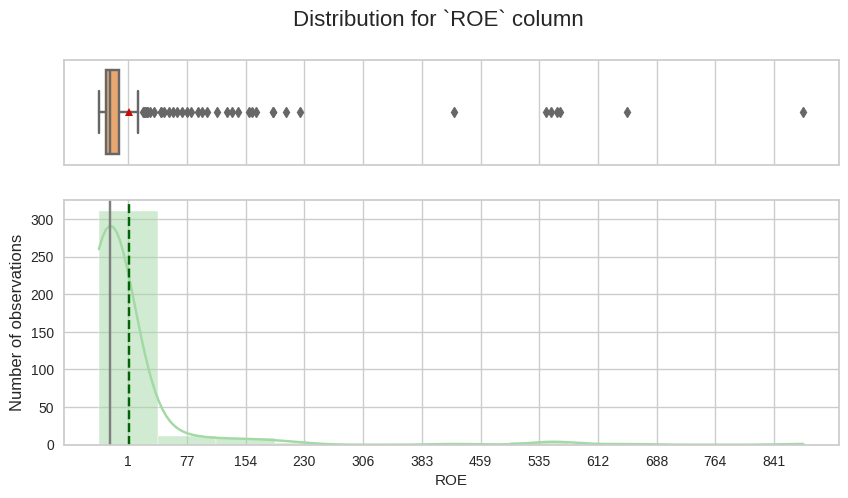

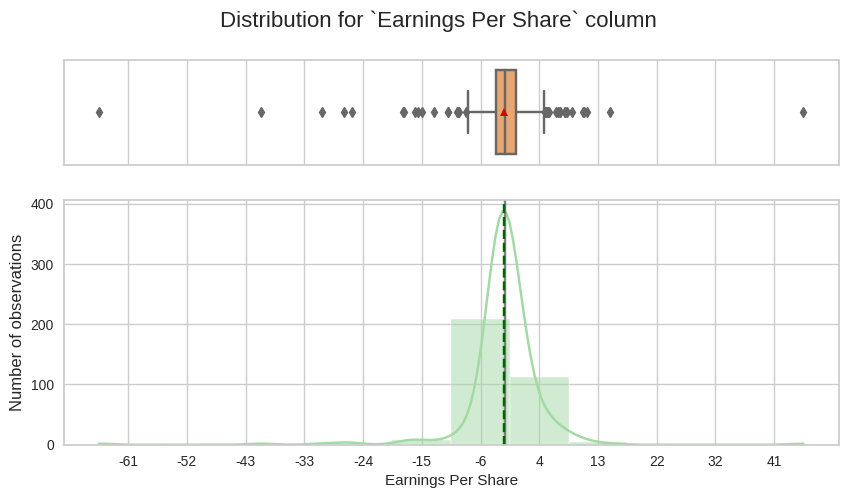

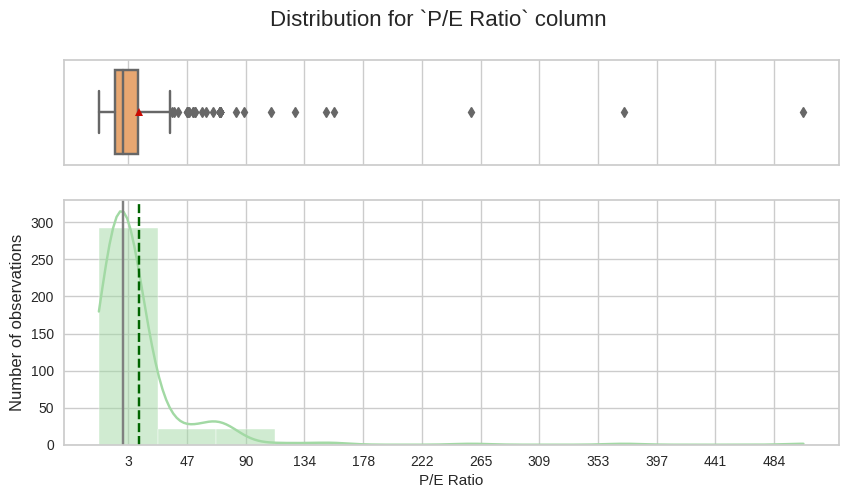

In [17]:
columns = df.select_dtypes(exclude='object').columns.to_list()
large = ['Net Cash Flow', 'Net Income', 'Estimated Shares Outstanding']
small = list(set(columns) - set(large))

for feature in small:
  histogram_boxplot(df, feature, figsize=(10, 5), bins=12, fmt='{:,.0f}')

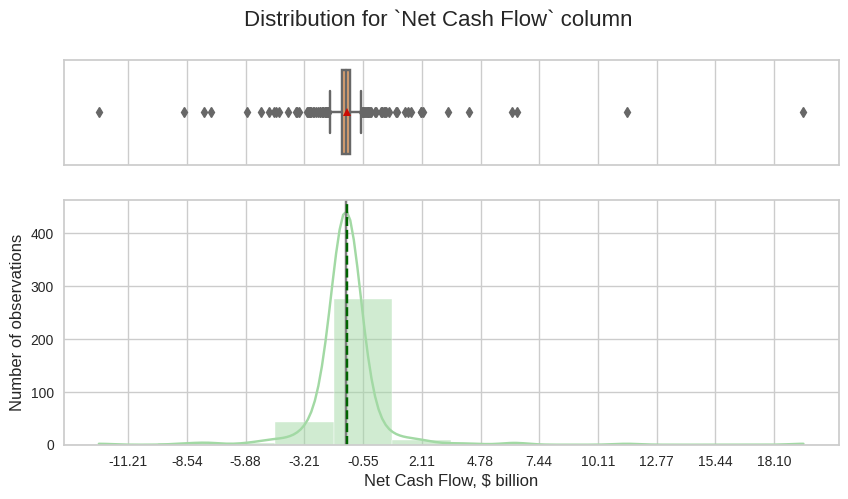

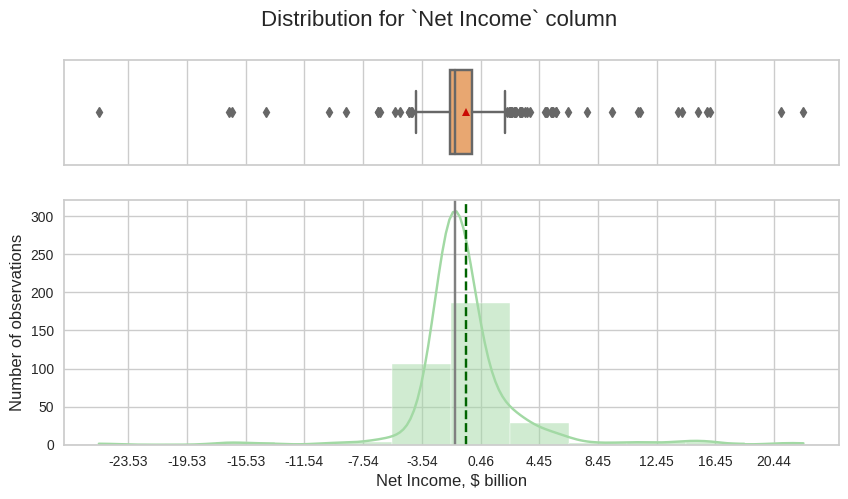

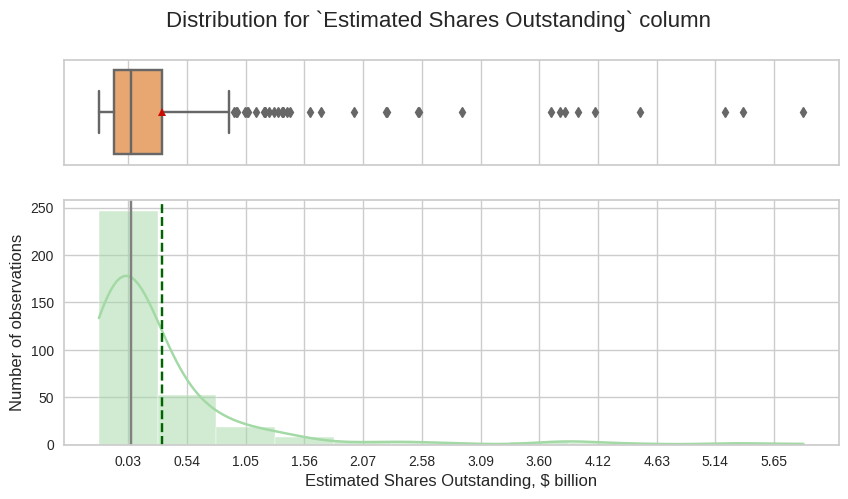

In [18]:
for feature in large:
  histogram_boxplot(df[large]/1e9, feature, figsize=(10, 5), bins=12, fmt='{:,.2f}', xlabel=feature+', $ billion')

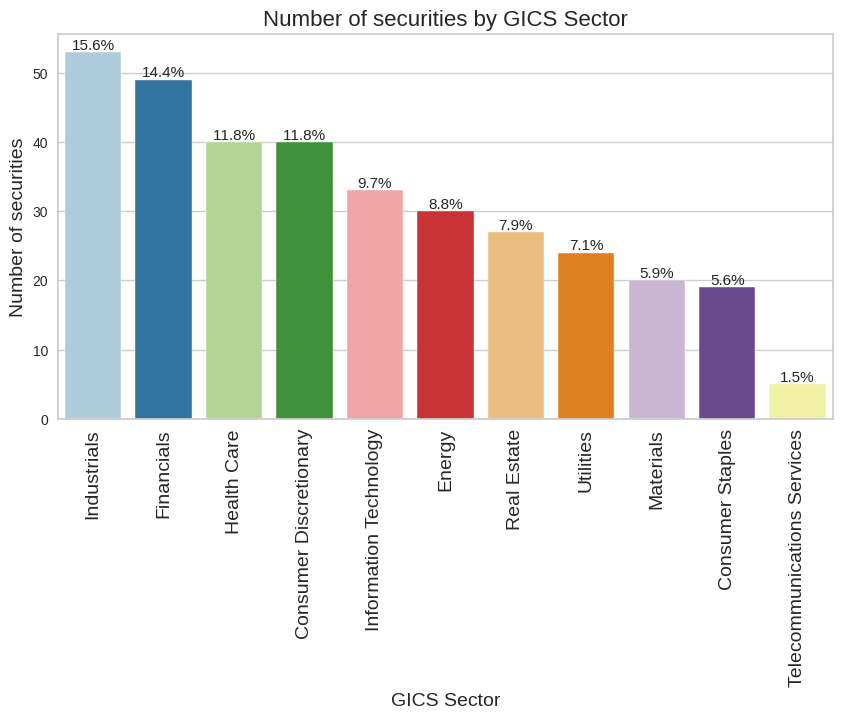

In [19]:
labled_countplot(data=df, feature='GICS Sector', perc=True,
                    title='Number of securities by GICS Sector',
                    figsize=(10, 5), ylabel='Number of securities',
                    xlabel='GICS Sector', orient='h', xlo=90)

**Observations:**

- Variables such as `Estimated Shares Outstanding`, `ROE`, `Cash Ratio`, `Current Price`, `Volatility`, and `P/E Ratio` exhibit right-skewed distributions with some upper outliers.
- Variables including `Earnings Per Share`, `Net Income`, `Net Cash Flow`, and `P/B Ratio` display some outliers in both the upper and lower ends of the distribution. Distributions are bell-shaped, close to normal.
- `The Price Change` variable demonstrates a distribution that closely resembles a bell-shaped curve, indicating a distribution that is close to normal. There are some positive and negative outliers.
- The distribution of securities across sectors is uneven. The `Industries` sector comprises the largest portion of securities at 15.6%, followed by `Financials` at 14.4%. The `Telecommunication Services` sector represents the smallest share with just 1.5% of securities.

### Bivariate Analysis


#### Pairplot of numerical variables

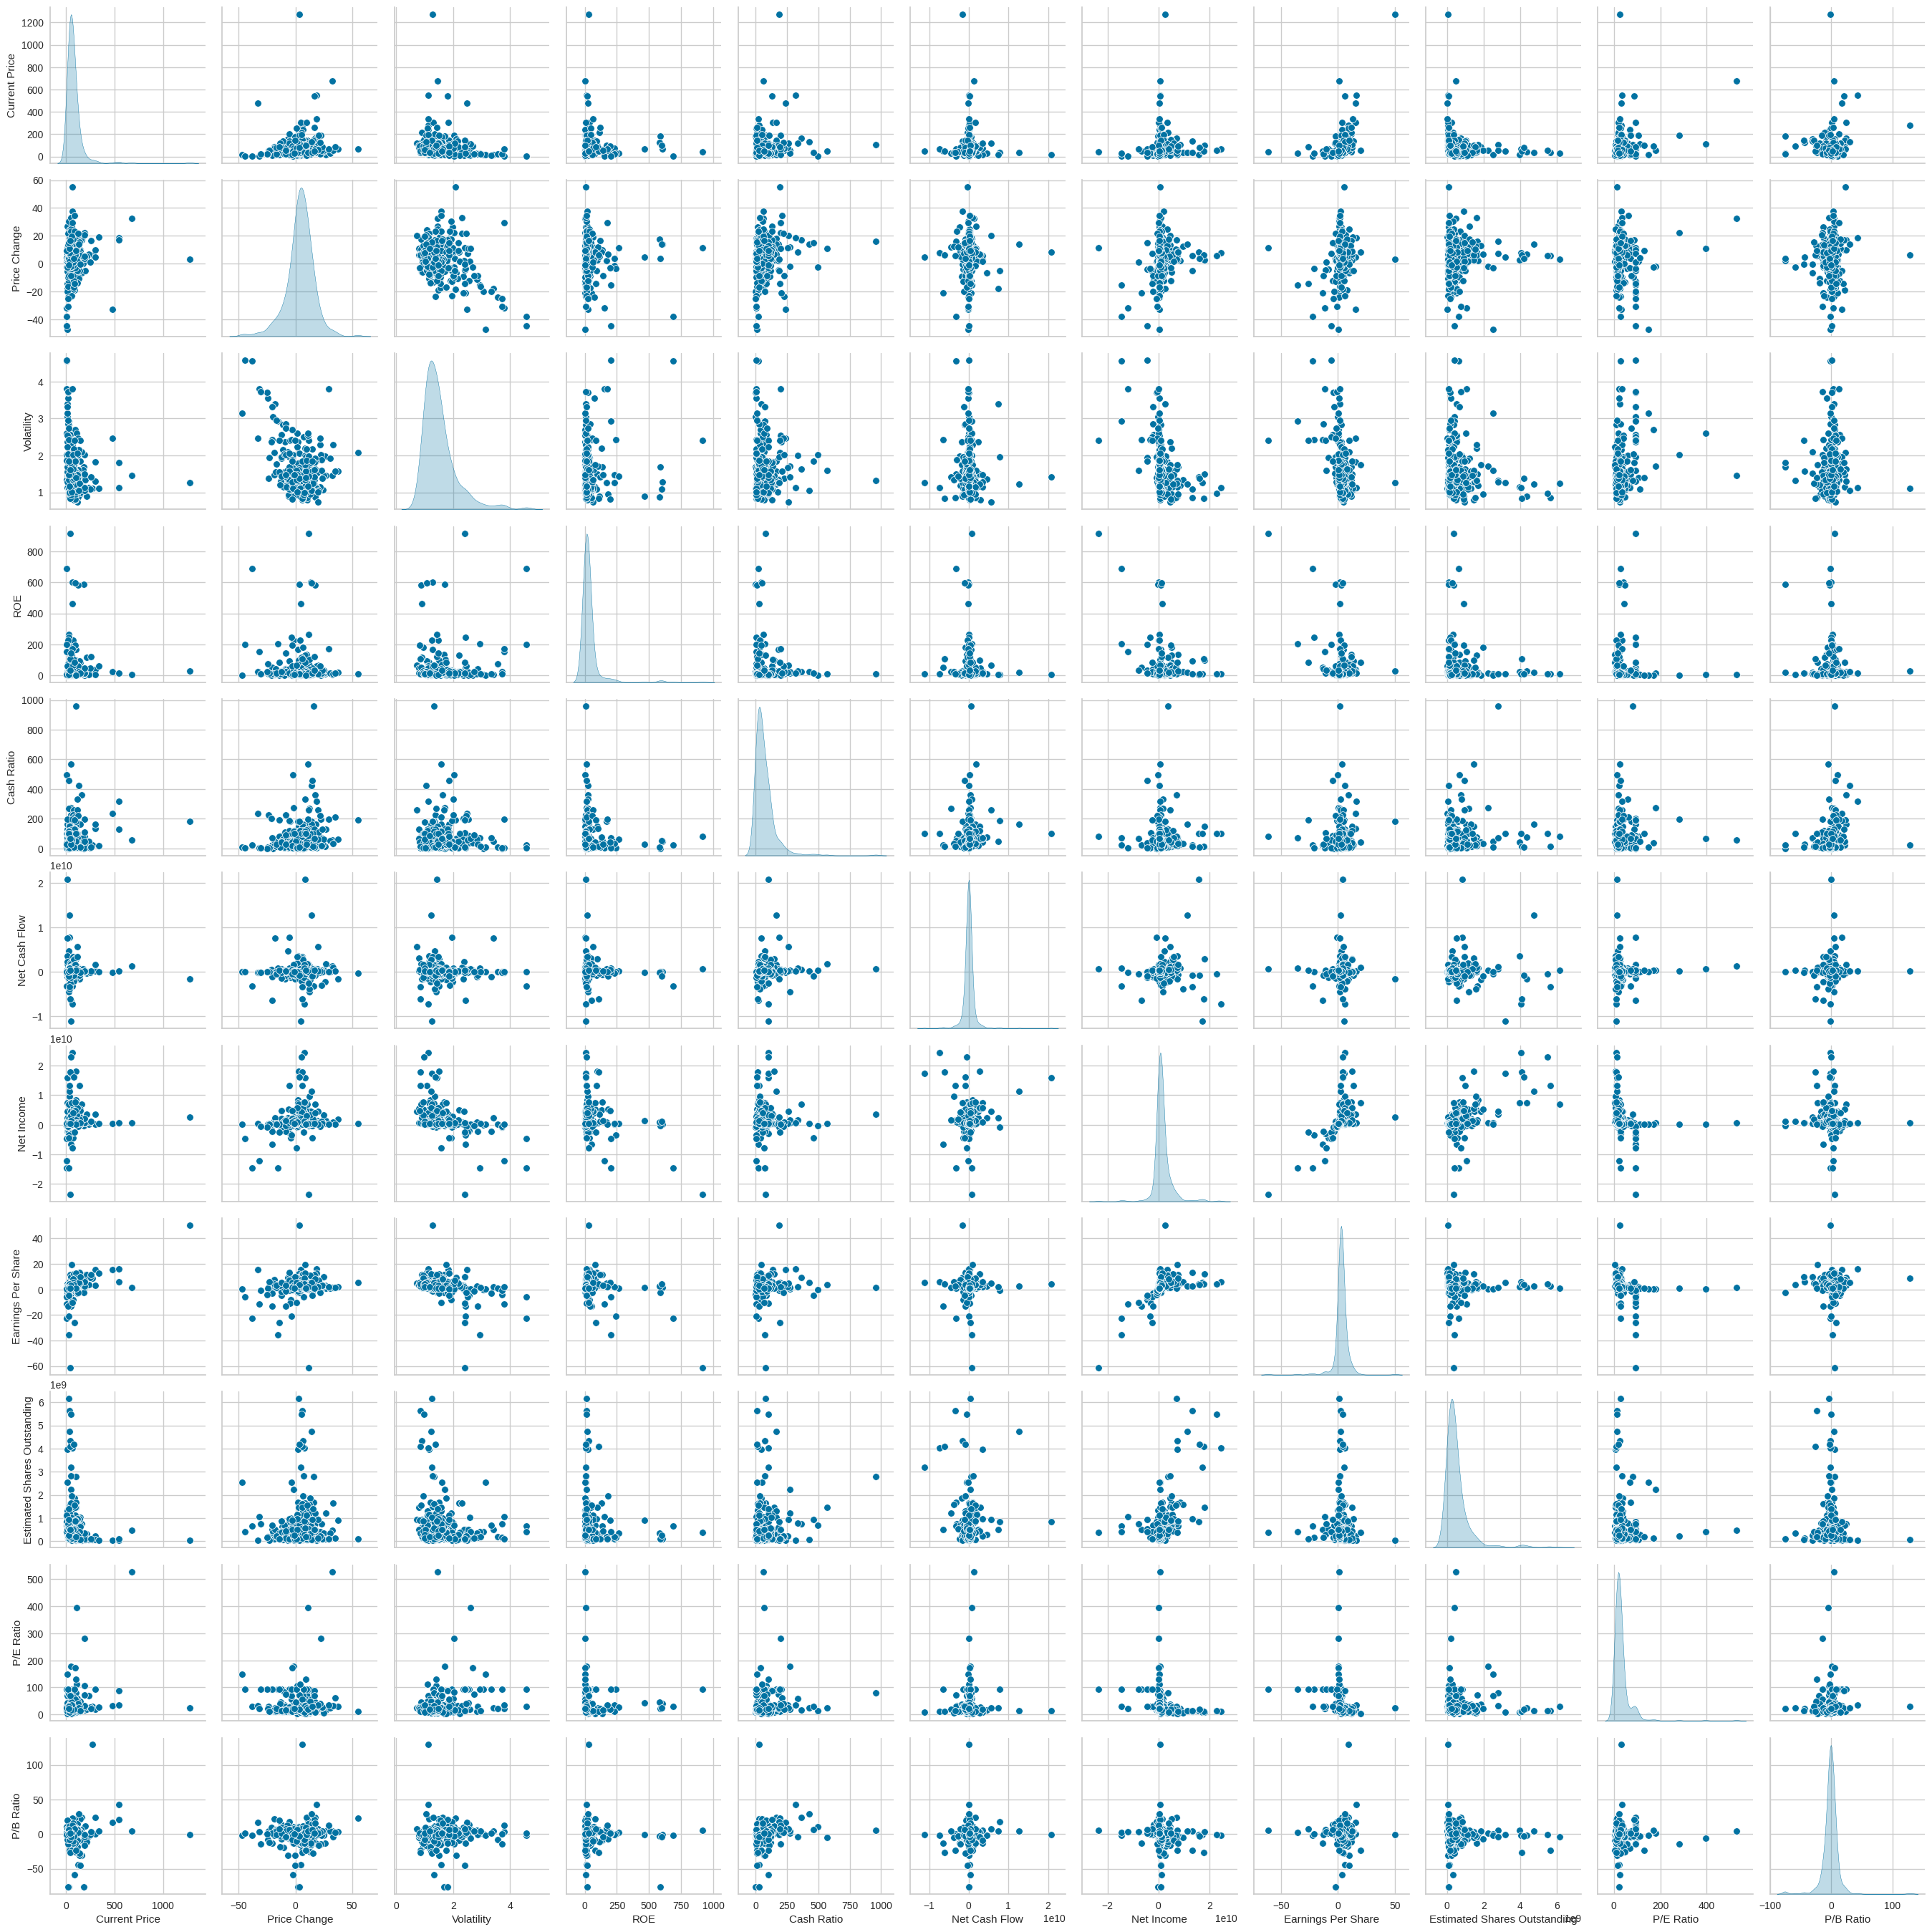

In [20]:
sns.pairplot(df, diag_kind='kde');

* It is challenging to determine the number of clusters in the dataset based solely on the variable distributions and KDEs. A more in-depth analysis is needed.

**Let's check the stocks' numerical parameters broken down by sectors.**

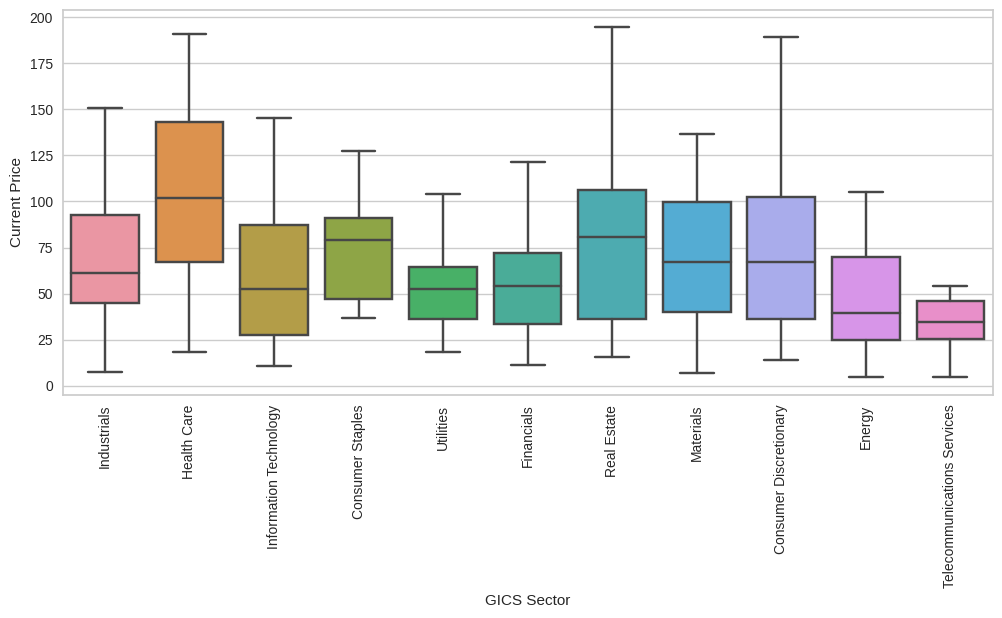

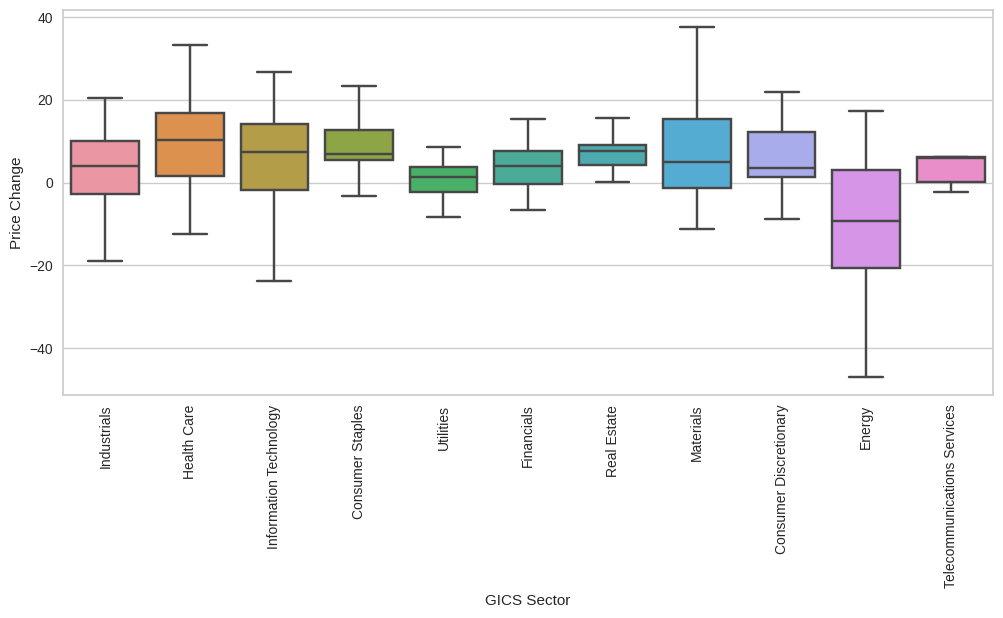

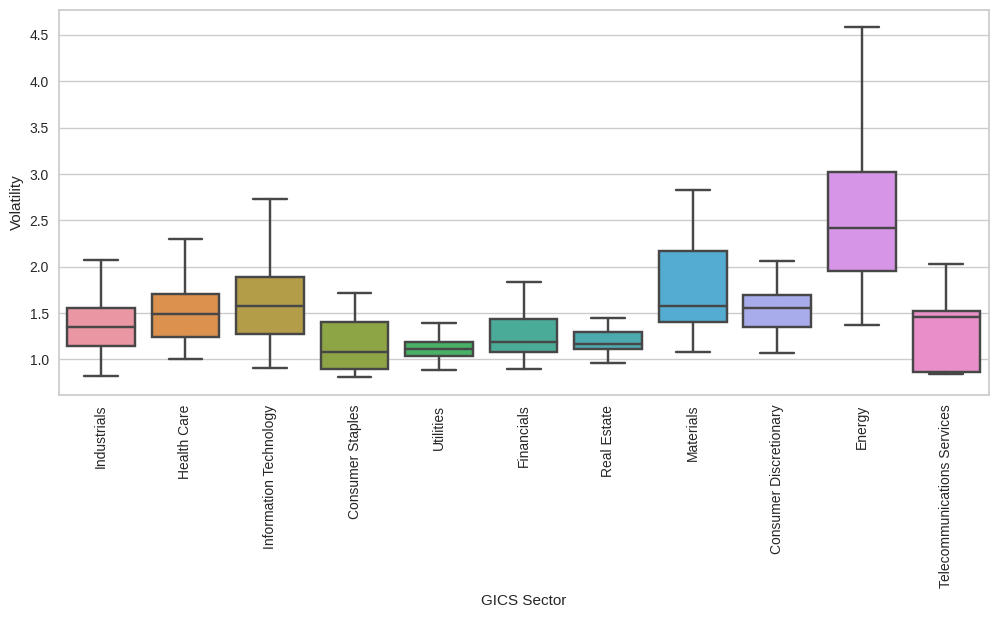

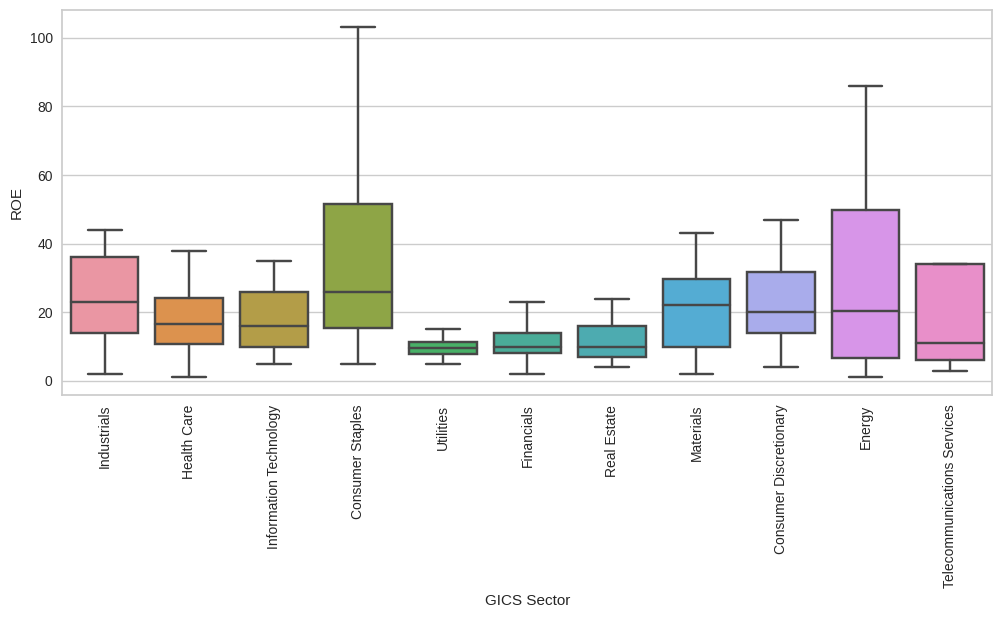

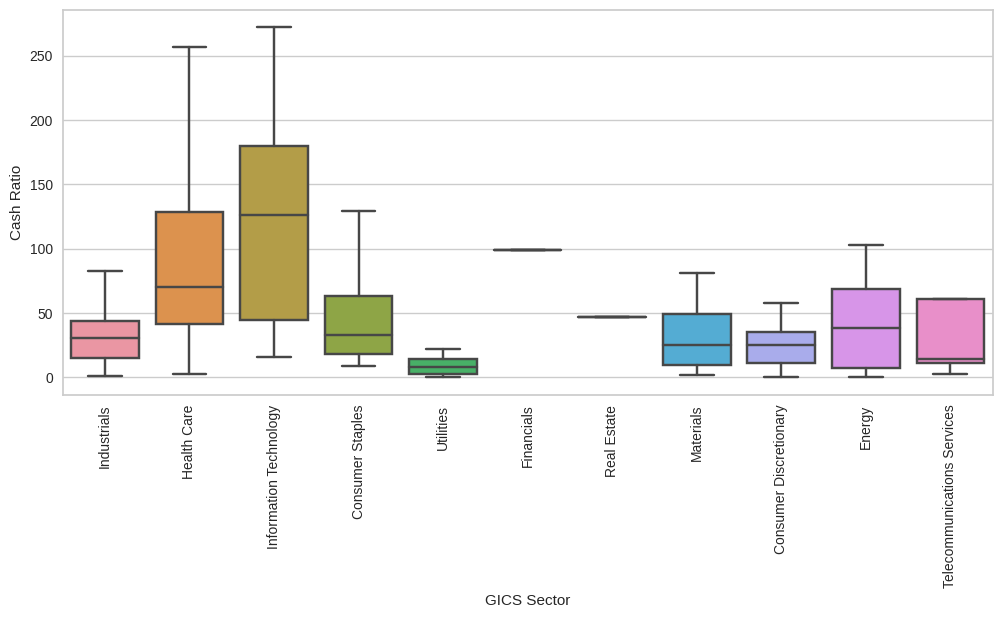

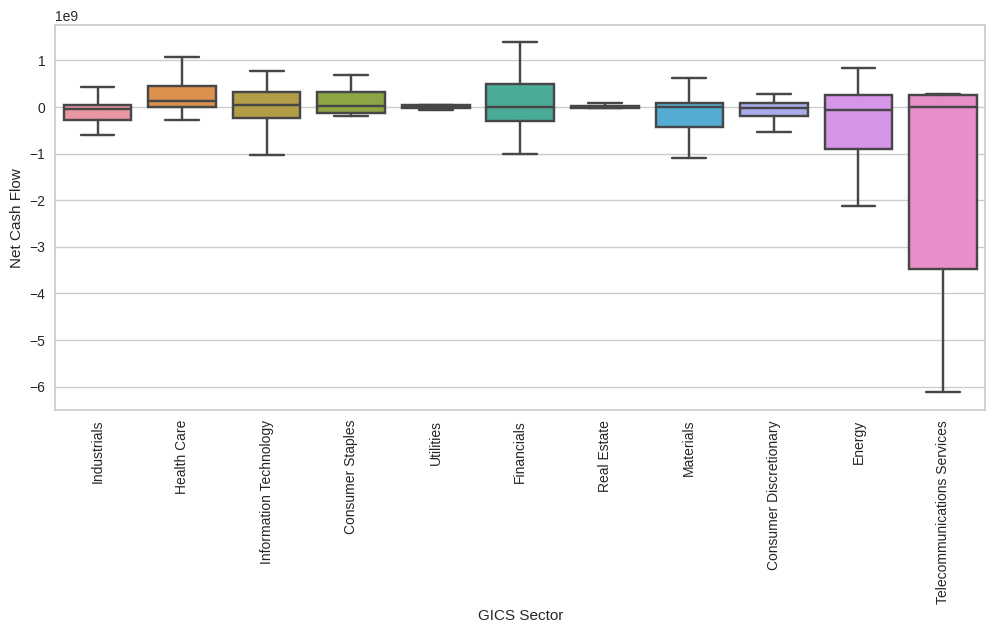

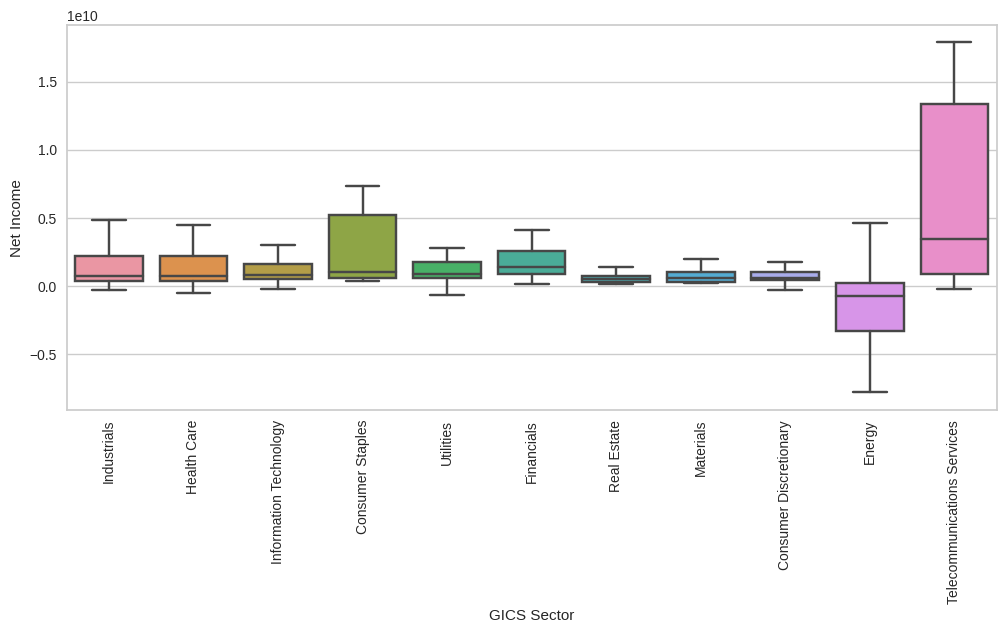

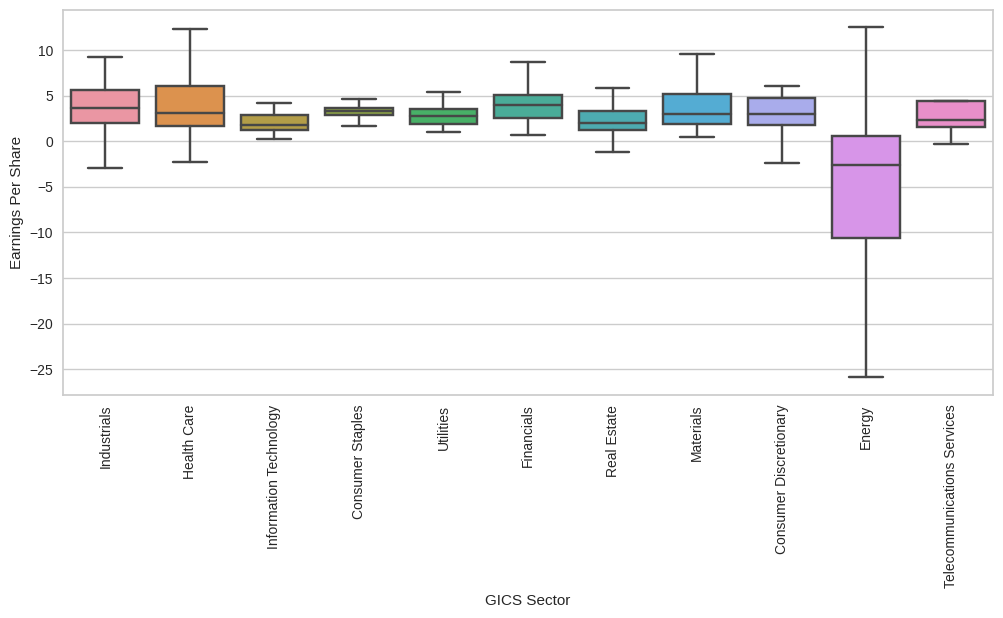

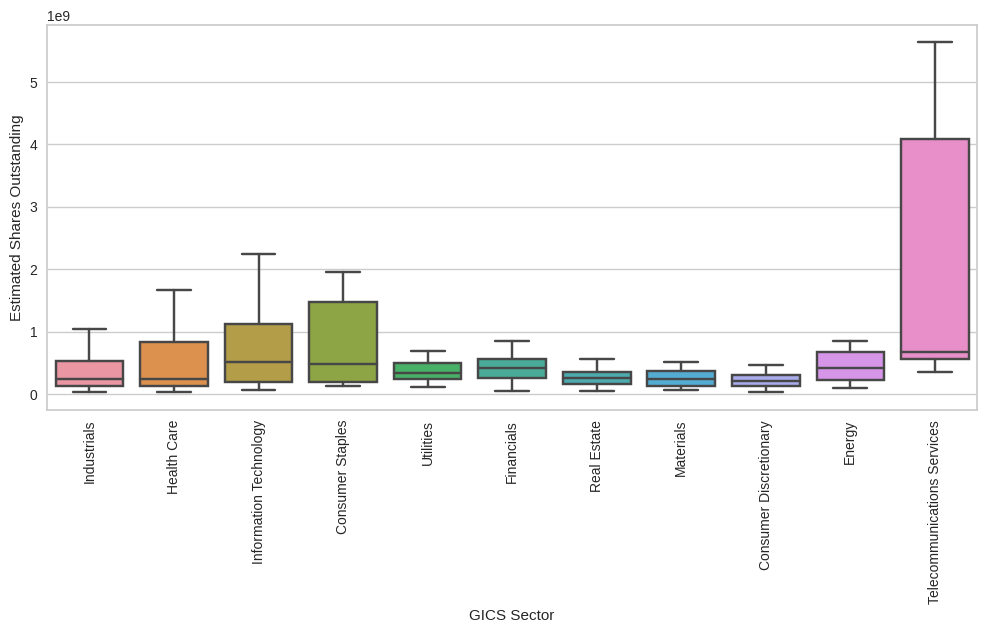

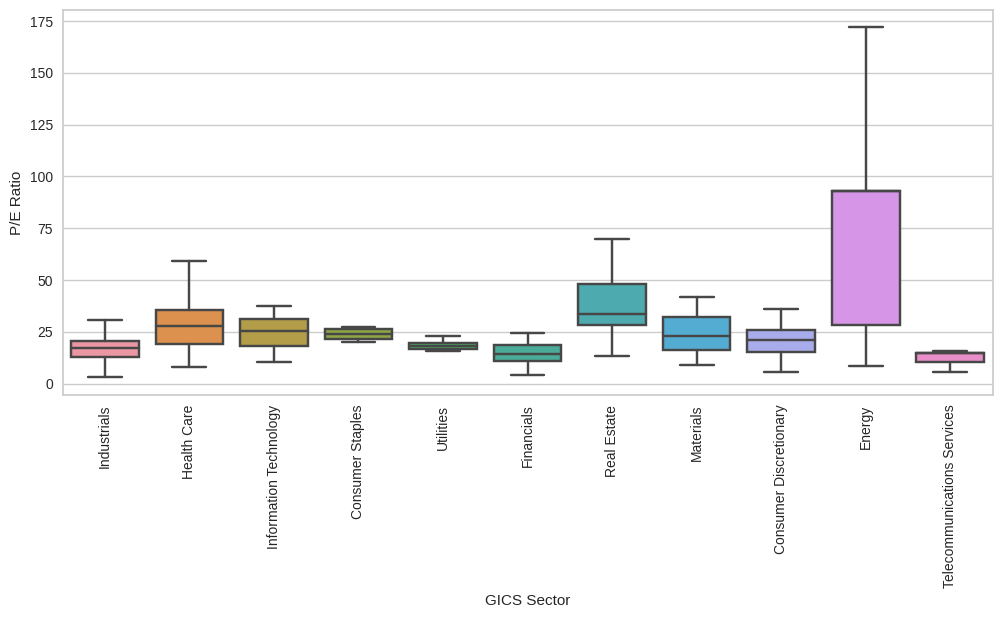

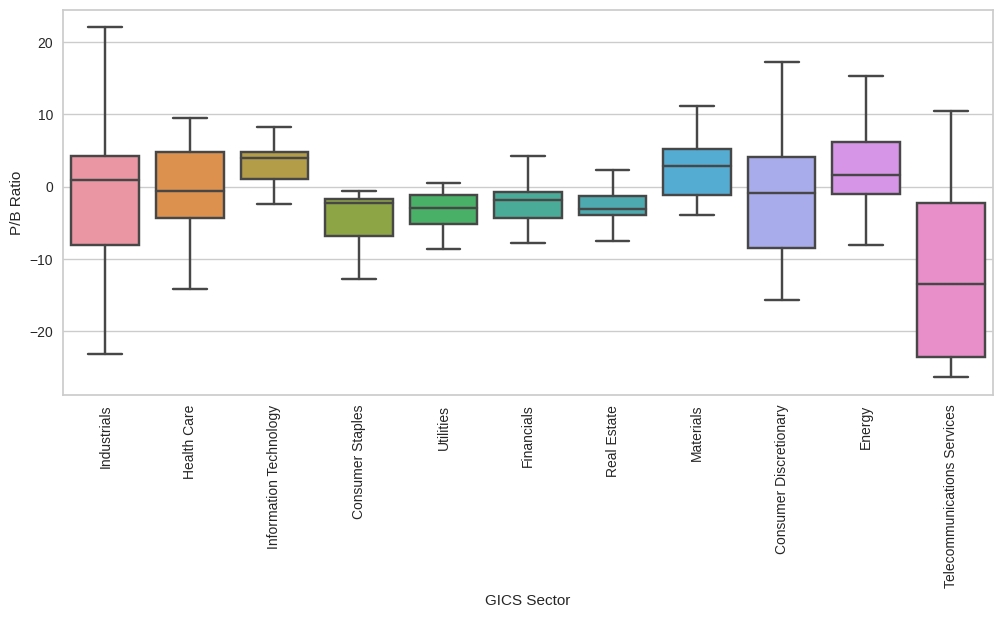

In [21]:
for col in df.select_dtypes(include='number').columns:
  plt.figure(figsize=(12, 5))
  sns.boxplot(data=df, y=col, x='GICS Sector', showfliers=False)
  plt.xticks(rotation=90)
  plt.show()

By examining the boxplots, we can make the following conclusions:

**Current Price:**
* The Consumer Discretionary, Health Care, Information Technology, and Real Estate sectors have the highest median current prices, while the Energy sector has the lowest median.
* The Telecommunications Services and Utilities sectors have the least variability in current prices, as indicated by the narrow interquartile range.

**Price Change:**
* The Energy sector has the most negative price change, with the lowest median and highest lower quartile value.
* The Financials and Health Care sectors have relatively higher price change, as shown by their higher median values.

**Volatility:**
* The Energy sector exhibits the highest volatility, with the widest interquartile range and the highest maximum value.
* The Consumer Staples and Utilities sectors have the lowest volatility, as indicated by their narrow interquartile ranges.

**ROE (Return on Equity):**
* The Consumer Discretionary and Health Care sectors have the highest median ROE values, indicating better profitability.
* The Energy and Telecommunications Services sectors have the lowest median ROE values, suggesting lower profitability.

**Cash Ratio:**
* The Real Estate sector has the highest median cash ratio, indicating a higher ability to cover short-term obligations.
* The Consumer Discretionary sector has the lowest median cash ratio, suggesting a relatively lower ability to cover short-term obligations.

**Net Cash Flow:**
* The Information Technology and Real Estate sectors have the highest median net cash flow values, indicating positive cash flow.
* The Energy sector has the most negative net cash flow, as shown by the lowest median value and the highest lower quartile value.

**Net Income:**
* The Health Care sector has the highest median net income, indicating higher profitability.
* The Energy sector has the lowest median net income, suggesting lower profitability.

**Earnings Per Share (EPS):**
* The Energy sector has the highest median EPS value, indicating higher earnings per share.
* The Consumer Discretionary sector has the lowest median EPS value, suggesting lower earnings per share.

**Estimated Shares Outstanding:**
* The Real Estate sector has the highest median estimated shares outstanding, indicating a higher number of outstanding shares.
* The Telecommunications Services sector has the lowest median estimated shares outstanding, suggesting a lower number of outstanding shares.

**P/E Ratio:**
* The Energy and Telecommunications Services sectors have relatively higher P/E ratios, indicating higher valuation compared to earnings.
* The Financials and Industrials sectors have relatively lower P/E ratios, suggesting lower valuation compared to earnings.

**P/B Ratio:**
* The Energy and Telecommunications Services sectors have relatively higher P/B ratios, indicating higher valuation compared to book value.
* The Consumer Staples and Utilities sectors have relatively lower P/B ratios, suggesting lower valuation compared to book value.

*Overall, analyzing the boxplot charts and considering the removal of outliers helps in identifying the range, central tendency, and dispersion of each variable within the different GICS sectors. It provides insights into the variations and characteristics of the sectors' financial metrics.*

**Let's check the stocks of which economic sector have seen the maximum price increase on average.**

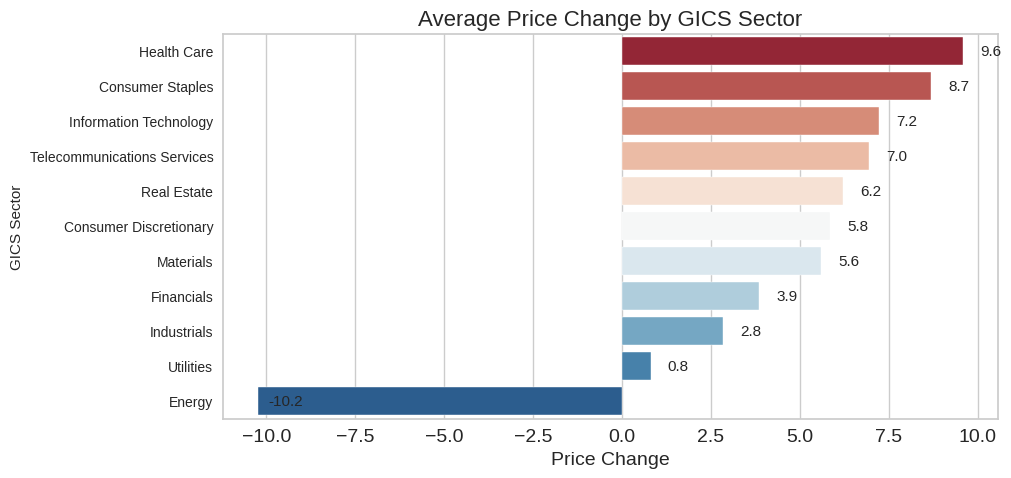

In [22]:
labled_barplot(data=df, feature='Price Change', fmt="{:.1f}", rnd=2,
                    title='Average Price Change by GICS Sector',
                    figsize=(10, 5), ylabel='Price Change',
                    groupby='GICS Sector', orient='v')

* The top 3 economic sectors with the highest average price increase are:
  1. Health Care (9.59),
  2. Consumer Staples (8.68), and 
  3. Information Technology (7.22).

**Volatility accounts for the fluctuation in the stock price. A stock with high volatility will witness sharper price changes, making it a riskier investment. Let's see how volatility varies, on average, across economic sectors.**

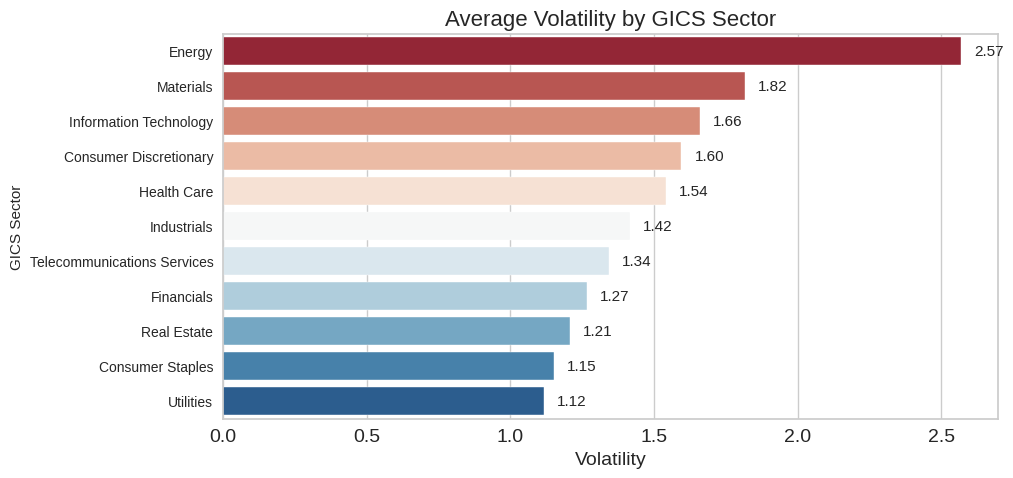

In [23]:
labled_barplot(data=df, feature='Volatility', fmt="{:.2f}", rnd=2,
                    title='Average Volatility by GICS Sector',
                    figsize=(10, 5), ylabel='Volatility',
                    groupby='GICS Sector', orient='v')

* From the data provided, the `Energy` sector has the highest average volatility (2.57), while the `Utilities` sector has the lowest average volatility (1.12).

**Number of companies in sector / sub industry**

In [24]:
df.pivot_table(index=['GICS Sector', 'GICS Sub Industry'],
               values='Ticker Symbol', 
               aggfunc='count').style\
    .set_table_styles([dict(selector="th", props=[('text-align', 'right')])])\
    .highlight_max(color='lightgreen')\
    .format('{:.0f}', na_rep='--')

* The sub-sector `Oil & Gas Exploration & Production` within the `Energy` sector has the highest count of securities, with 16 in total. This is closely followed by the `REITs` sub-sector in `Real Estate`, which contains 14 securities.

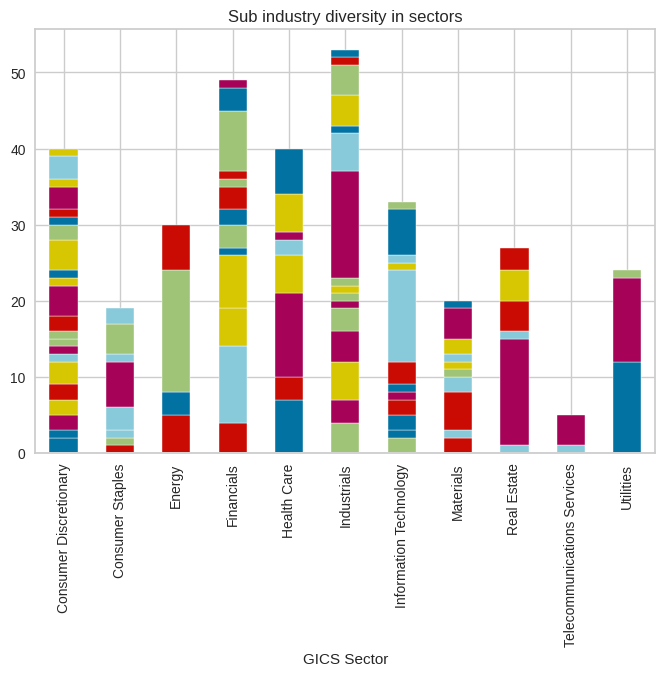

In [25]:
sectors = df.pivot_table(index='GICS Sector',
                         columns='GICS Sub Industry',
               values='Ticker Symbol', 
               aggfunc='count').reset_index()

sectors.plot(x='GICS Sector', kind='bar', stacked=True,
        title='Sub industry diversity in sectors', legend=False);

**Questions**:

1. What does the distribution of stock prices look like?
2. The stocks of which economic sector have seen the maximum price increase on average?
3. How are the different variables correlated with each other?
4. Cash ratio provides a measure of a company's ability to cover its short-term obligations using only cash and cash equivalents. How does the average cash ratio vary across economic sectors?
5. P/E ratios can help determine the relative value of a company's shares as they signify the amount of money an investor is willing to invest in a single share of a company per dollar of its earnings. How does the P/E ratio vary, on average, across economic sectors?

**1. What does the distribution of stock prices look like?**


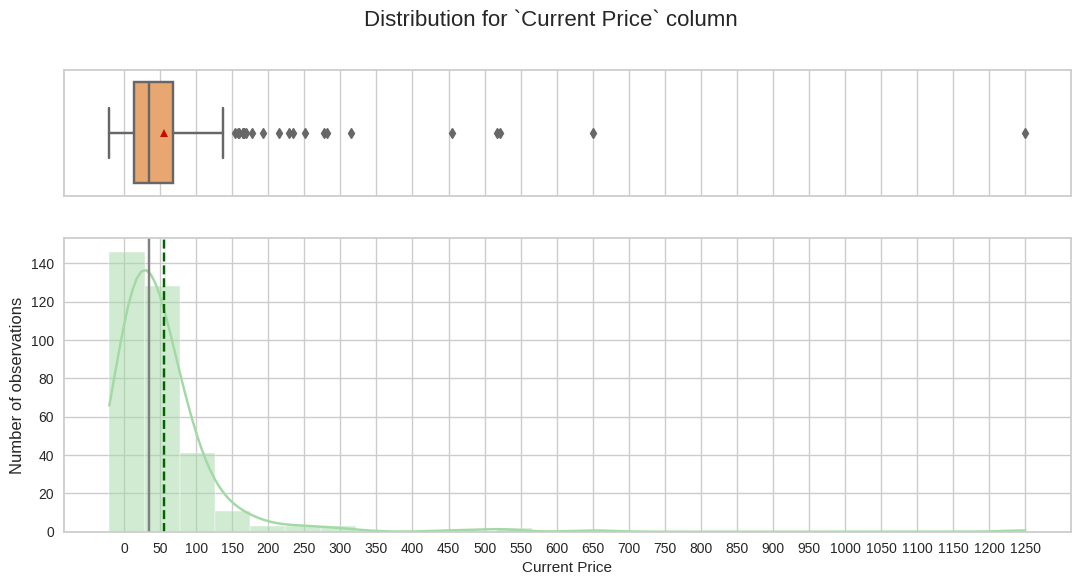

In [26]:
histogram_boxplot(data=df, feature='Current Price', figsize=(13, 6), step=50, fmt='{:.0f}')

* The distribution of stock prices is positively skewed. This is because while there is a lower limit on stock prices (they cannot go below zero), there is no upper limit. So there can be a few stocks with very high prices that pull the average up, while the majority of stock prices may be lower.
* The distribution also shows some outliers towards the higher end of the price range, suggesting the presence of a few stocks with significantly higher prices.

In [27]:
desc = df['Current Price'].describe()
desc

count     340.000000
mean       80.862345
std        98.055086
min         4.500000
25%        38.555000
50%        59.705000
75%        92.880001
max      1274.949951
Name: Current Price, dtype: float64

In [28]:
irq = desc['75%'] - desc['25%']

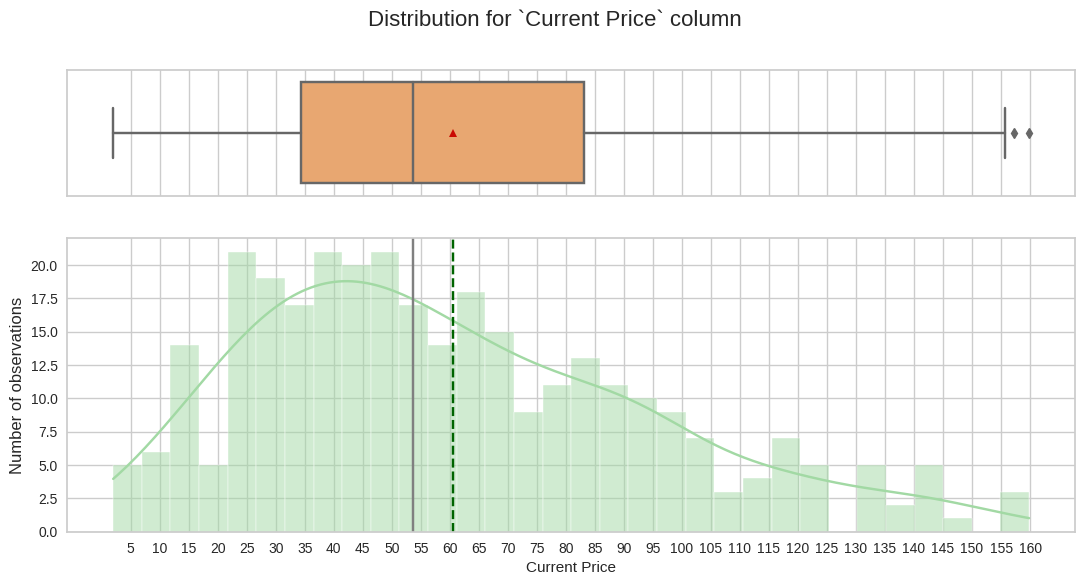

In [29]:
histogram_boxplot(data=df[df['Current Price'] < desc['75%'] + 1.5 * irq], feature='Current Price', figsize=(13, 6), step=5, fmt='{:.0f}')

* The distribution of stock prices without outliers is still right-skewed.

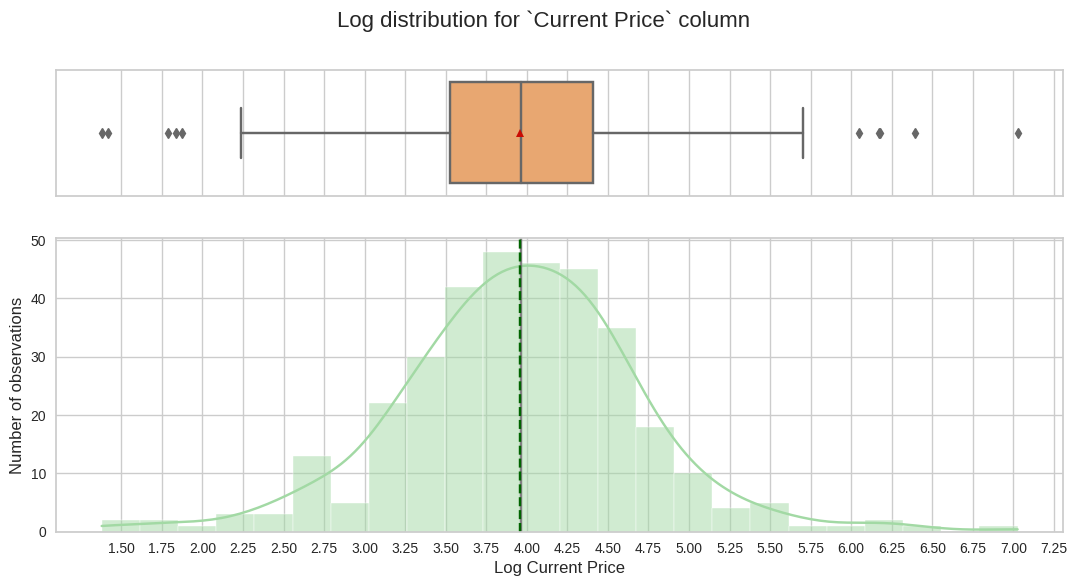

In [30]:
histogram_boxplot(data=df[['Current Price']].apply(np.log), step=0.25, fmt='{:.2f}',
                  feature='Current Price', figsize=(13, 6),
                  title='Log distribution for `Current Price` column',
                  xlabel='Log Current Price')

* After log transformation, the distribution of stock prices seems to be closer to normal, with both the mean and median being about 4.0.

>* Log transformation is a commonly used mathematical manipulation in statistics. It can help to make data more 'normal-like' or symmetrical, especially in situations where data are skewed. However, it doesn't guarantee to render any data perfectly normally distributed.
* So, a log transformation can indeed help us reduce skewness and make the distribution more symmetrical.
* It's important to note that, while log transformations can assist with certain statistical analyses, they won't necessarily capture all aspects of stock price movements.

**2. The stocks of which economic sector have seen the maximum price increase on average?**

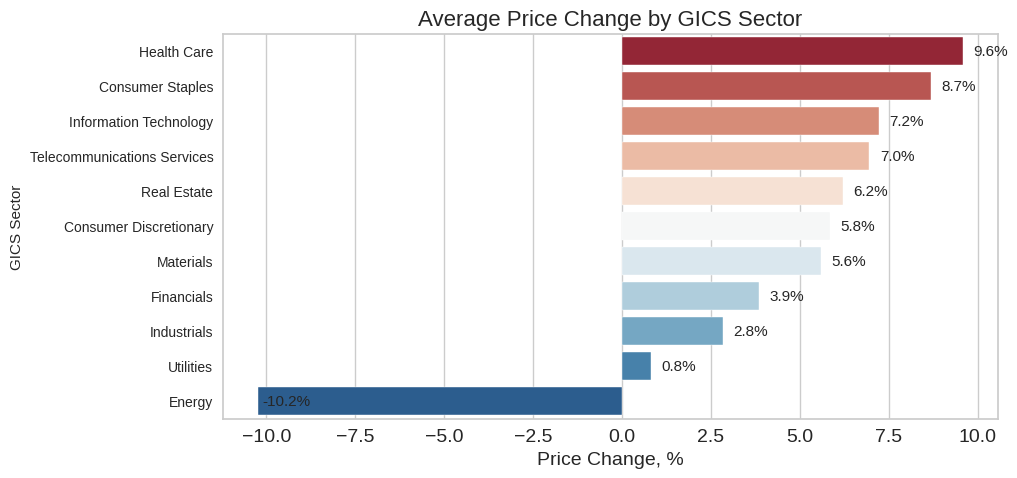

In [31]:
labled_barplot(data=df, feature='Price Change', fmt="{:.1f}%", rnd=2,
                    title='Average Price Change by GICS Sector',
                    figsize=(10, 5), ylabel='Price Change, %',
                    groupby='GICS Sector', orient='v')

* The Health Care sector has seen the maximum average price increase, with an average increase of 9.6%.

**3. How are the different variables correlated with each other?**

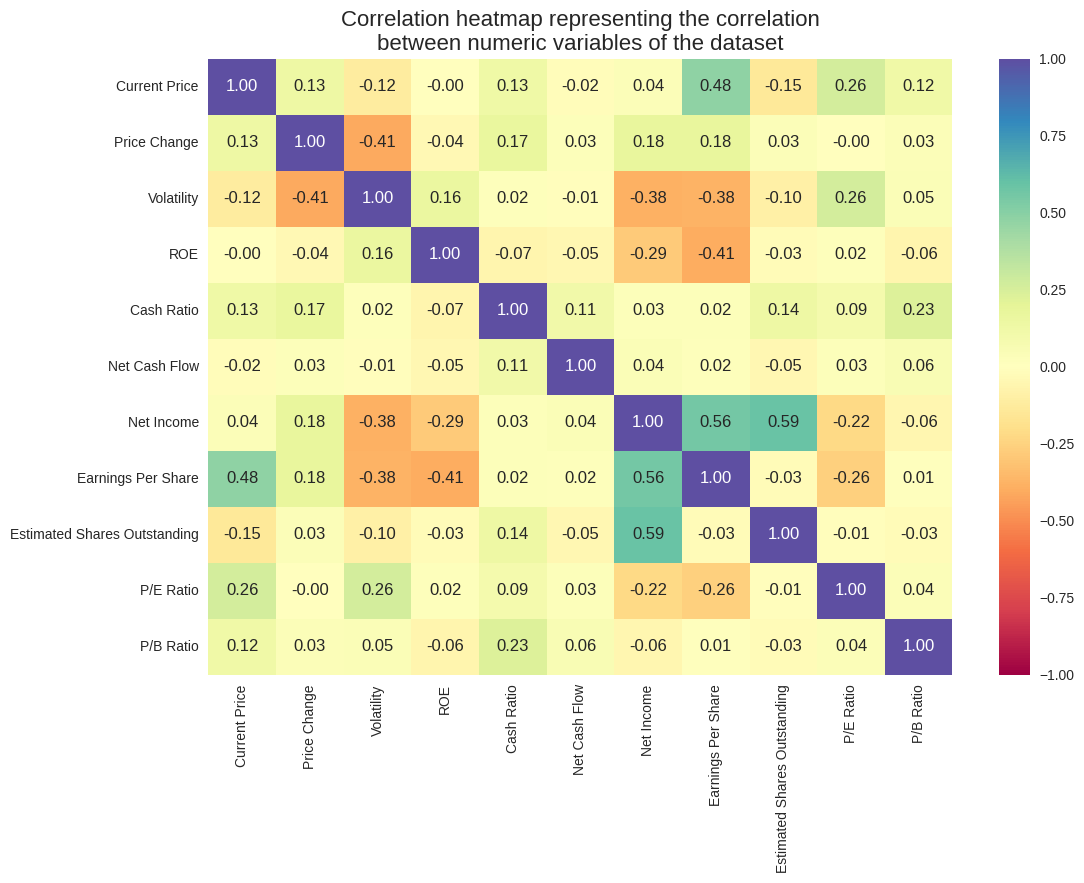

In [32]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.xlabel('')
plt.ylabel('')
plt.title('Correlation heatmap representing the correlation\nbetween numeric variables of the dataset',
          fontsize=16)
plt.show();

**Observations:**
- Moderate positive correlation:
  - `Net Income` and `Estimated Shares Outstanding` (0.59),
  - `Net Income` and `Earnings Per Share` (0.56),
  - `Current Price` and `Earnings Per Share (EPS)` (0.48).

- Weak positive correlation:
  - `Current Price` and `P/E Ratio` (0.26),
  - `Volatility` and `P/E Ratio` (0.26),
  - `Cash Ratio` and `P/B Ratio` (0.23).

- Moderate negative correlation:
  - `Price Change` and `Volatility` (-0.41),
  - `Earnings Per Share (EPS)` and `Return on Equity (ROE)` (-0.41),
  - `Net Income` and `Volatility` (-0.38),
  - `Volatility` and `Earnings Per Share (EPS)` (-0.38).

- Weak negative correlation:
  - `Return on Equity (ROE)` and `Net Income` (-0.29),
  - `P/E Ratio` and `Earnings Per Share` (-0.26),
  - `P/E Ratio` and `Net Income` (-0.22).

**4. Cash ratio provides a measure of a company's ability to cover its short-term obligations using only cash and cash equivalents. How does the average cash ratio vary across economic sectors?**

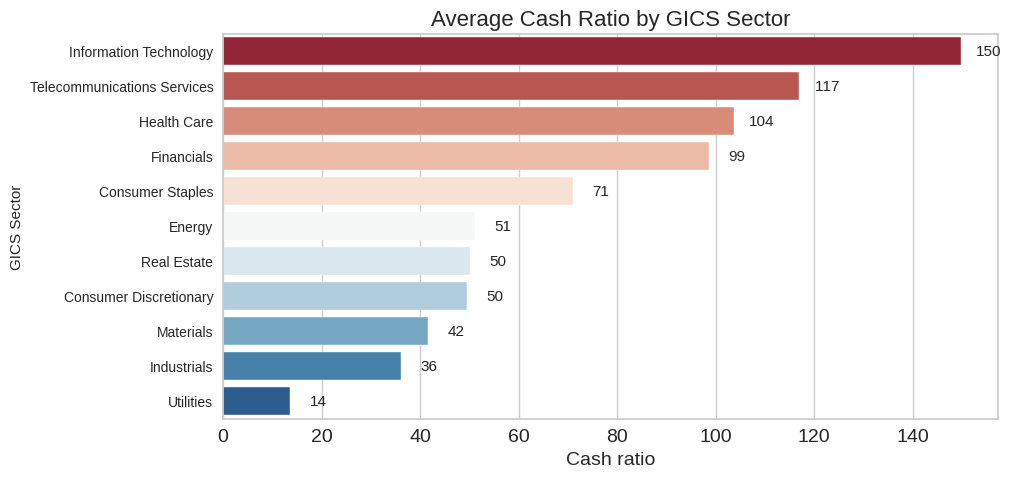

In [33]:
labled_barplot(data=df, feature='Cash Ratio', fmt="{:.0f}", rnd=2,
                    title='Average Cash Ratio by GICS Sector',
                    figsize=(10, 5), ylabel='Cash ratio',
                    groupby='GICS Sector', orient='v')

* The `Information Technology` sector has the highest average cash ratio (149.82), while the `Utilities` sector has the lowest average cash ratio (13.63).

**5. P/E ratios can help determine the relative value of a company's shares as they signify the amount of money an investor is willing to invest in a single share of a company per dollar of its earnings. How does the P/E ratio vary, on average, across economic sectors?**

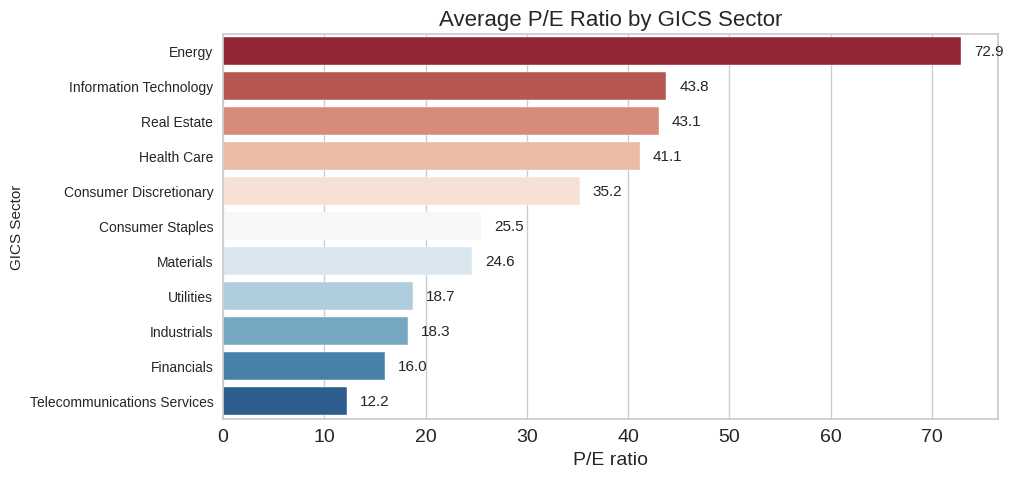

In [34]:
labled_barplot(data=df, feature='P/E Ratio', fmt="{:.1f}", rnd=2,
                    title='Average P/E Ratio by GICS Sector',
                    figsize=(10, 5), ylabel='P/E ratio',
                    groupby='GICS Sector', orient='v')

* The `Energy` sector has the highest average P/E ratio (72.9), while the `Telecommunications Services` sector has the lowest average P/E ratio (12.2).

## Data Preprocessing

- Duplicate value check
- Missing value treatment
- Outlier check
- Feature engineering (if needed)
- Any other preprocessing steps (if needed)

**Duplicate value check**


In [35]:
df.duplicated().sum()

0

* There are no duplicate values in the dataset

**Missing value treatment**

In [36]:
df.isna().sum().sum()


0

* There are no missing (Null, NA) values in the dataset

**Outlier check**

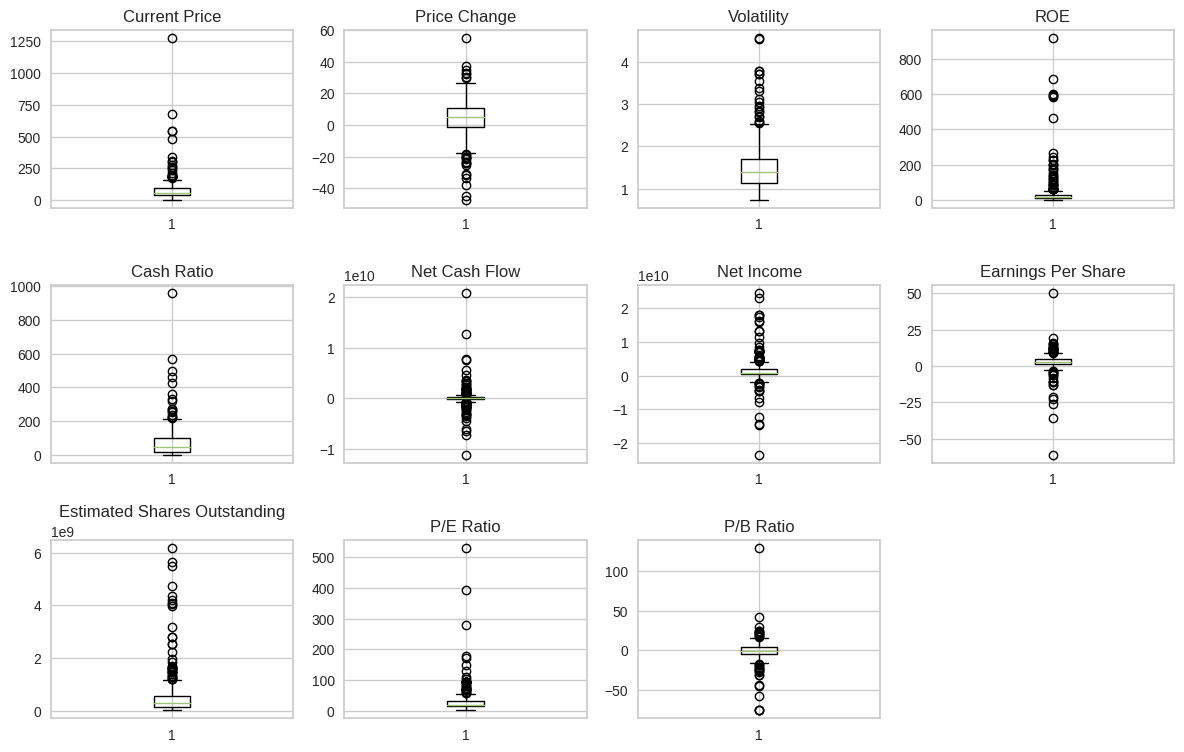

In [37]:
# outlier detection using boxplot
numeric_columns = df.select_dtypes(include=[int, float]).columns.tolist()

plt.figure(figsize=(12, 10))

for i, variable in enumerate(numeric_columns):
    plt.subplot(4, 4, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show();

* There are quite a few observations at the extremes of each variable, which could be considered outliers. 
* However, we will not remove all such data points, as they represent genuine trends.

**Feature engineering (if needed)**


>Wrong data
* Wrong data refers to data that is incorrect, inaccurate, or does not reflect reality.
* Such data may have been inputted incorrectly, or there may have been errors in processing or recording the data. Wrong data can lead to incorrect analysis and decision-making.
* Therefore, it is important to carefully check the data to ensure that it is accurate before using it for any decision-making purposes.

* For this particular project, no feature engineering is required as the dataset is adequately prepared for analysis.

**Any other preprocessing steps (if needed)**

- **Scaling the dataset before clastering**

>*Since K-means clustering is distance-based, it is essential to scale our features to have a similar range. Standardization (subtracting the mean and dividing by the standard deviation) or normalization (scaling values between 0 and 1) are common scaling techniques.*

**Standardization** method will be used for our task.

In [38]:
# Scaling the dataset before clastering
num_col = df.select_dtypes(include='number').columns
scaler = StandardScaler()
subset = df[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

In [39]:
# Creating a dataframe from the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

In [40]:
subset_scaled_df.head()

Current Price  Price Change  Volatility       ROE  Cash Ratio  \
0      -0.393341      0.493950    0.272749  0.989601   -0.210698   
1      -0.220837      0.355439    1.137045  0.937737    0.077269   
2      -0.367195      0.602479   -0.427007 -0.192905   -0.033488   
3       0.133567      0.825696   -0.284802 -0.317379    1.218059   
4      -0.260874     -0.492636    0.296470 -0.265515    2.237018   

   Net Cash Flow  Net Income  Earnings Per Share  \
0      -0.339355    1.554415            1.309399   
1      -0.002335    0.927628            0.056755   
2       0.454058    0.744371            0.024831   
3      -0.152497   -0.219816           -0.230563   
4       0.133564   -0.202703           -0.374982   

   Estimated Shares Outstanding  P/E Ratio  P/B Ratio  
0                      0.107863  -0.652487  -0.506653  
1                      1.250274  -0.311769  -0.504205  
2                      1.098021  -0.391502   0.094941  
3                     -0.091622   0.947148   0.424333  
4                      1.978399   3.293307   0.199196

* No any other preprocessing steps are needed

## EDA

- It is a good idea to explore the data once again after manipulating it.

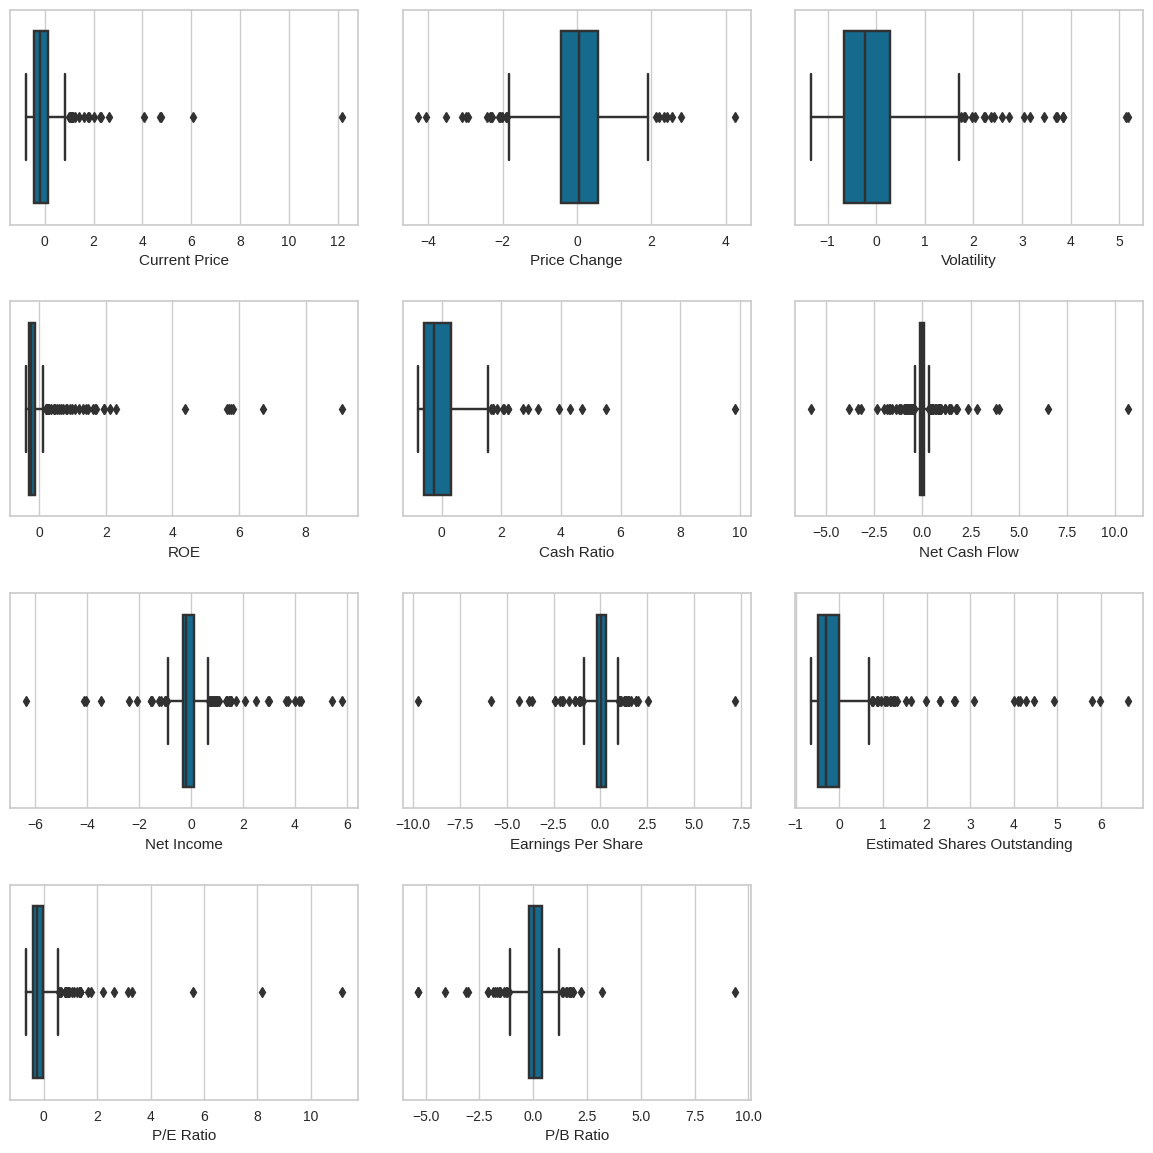

In [41]:
# Numerical variables
plt.figure(figsize=(12, 12))

for i, var in enumerate(num_col):
  plt.subplot(4, 3, i + 1)
  sns.boxplot(data=subset_scaled_df, x=var)
  plt.tight_layout(pad=2)

plt.tight_layout(pad=2);
plt.show();

**Categorical variables**

**`GICS Sub Industry`**

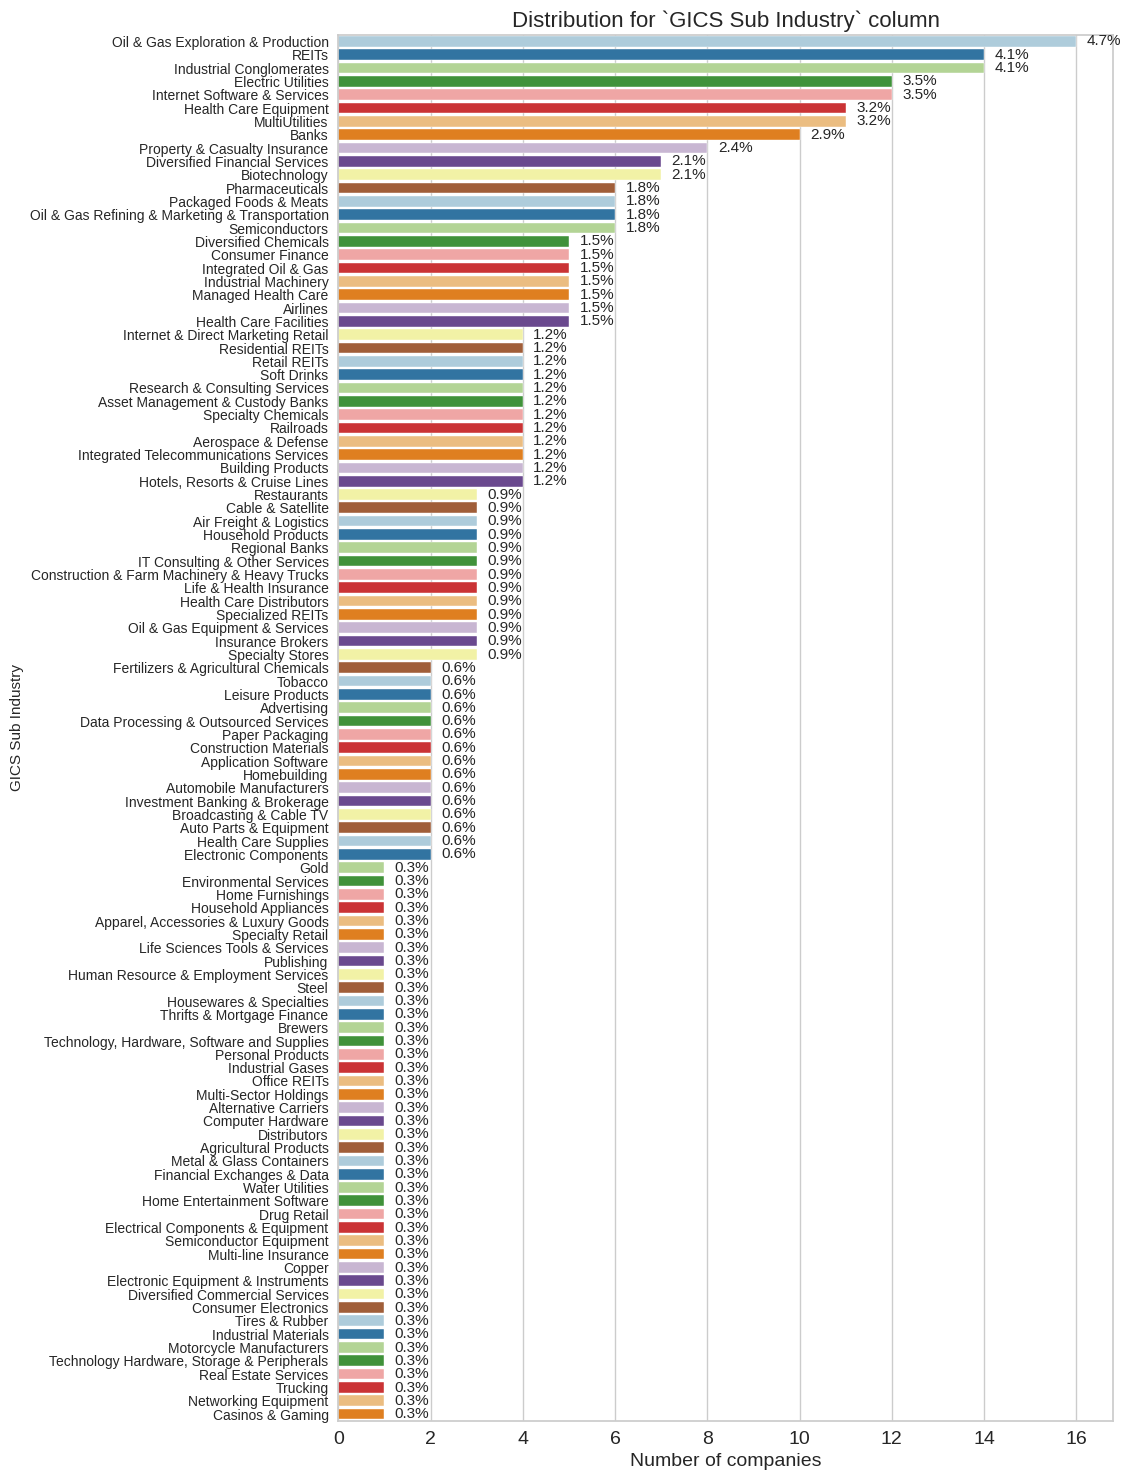

In [42]:
labled_countplot(data=df, feature='GICS Sub Industry',
                 perc=True, rnd=0,
                 figsize=(10, 18), 
                 ylabel='Number of companies',
                 orient='v')

**Let's repeat pairplot analysis on the scaled data**

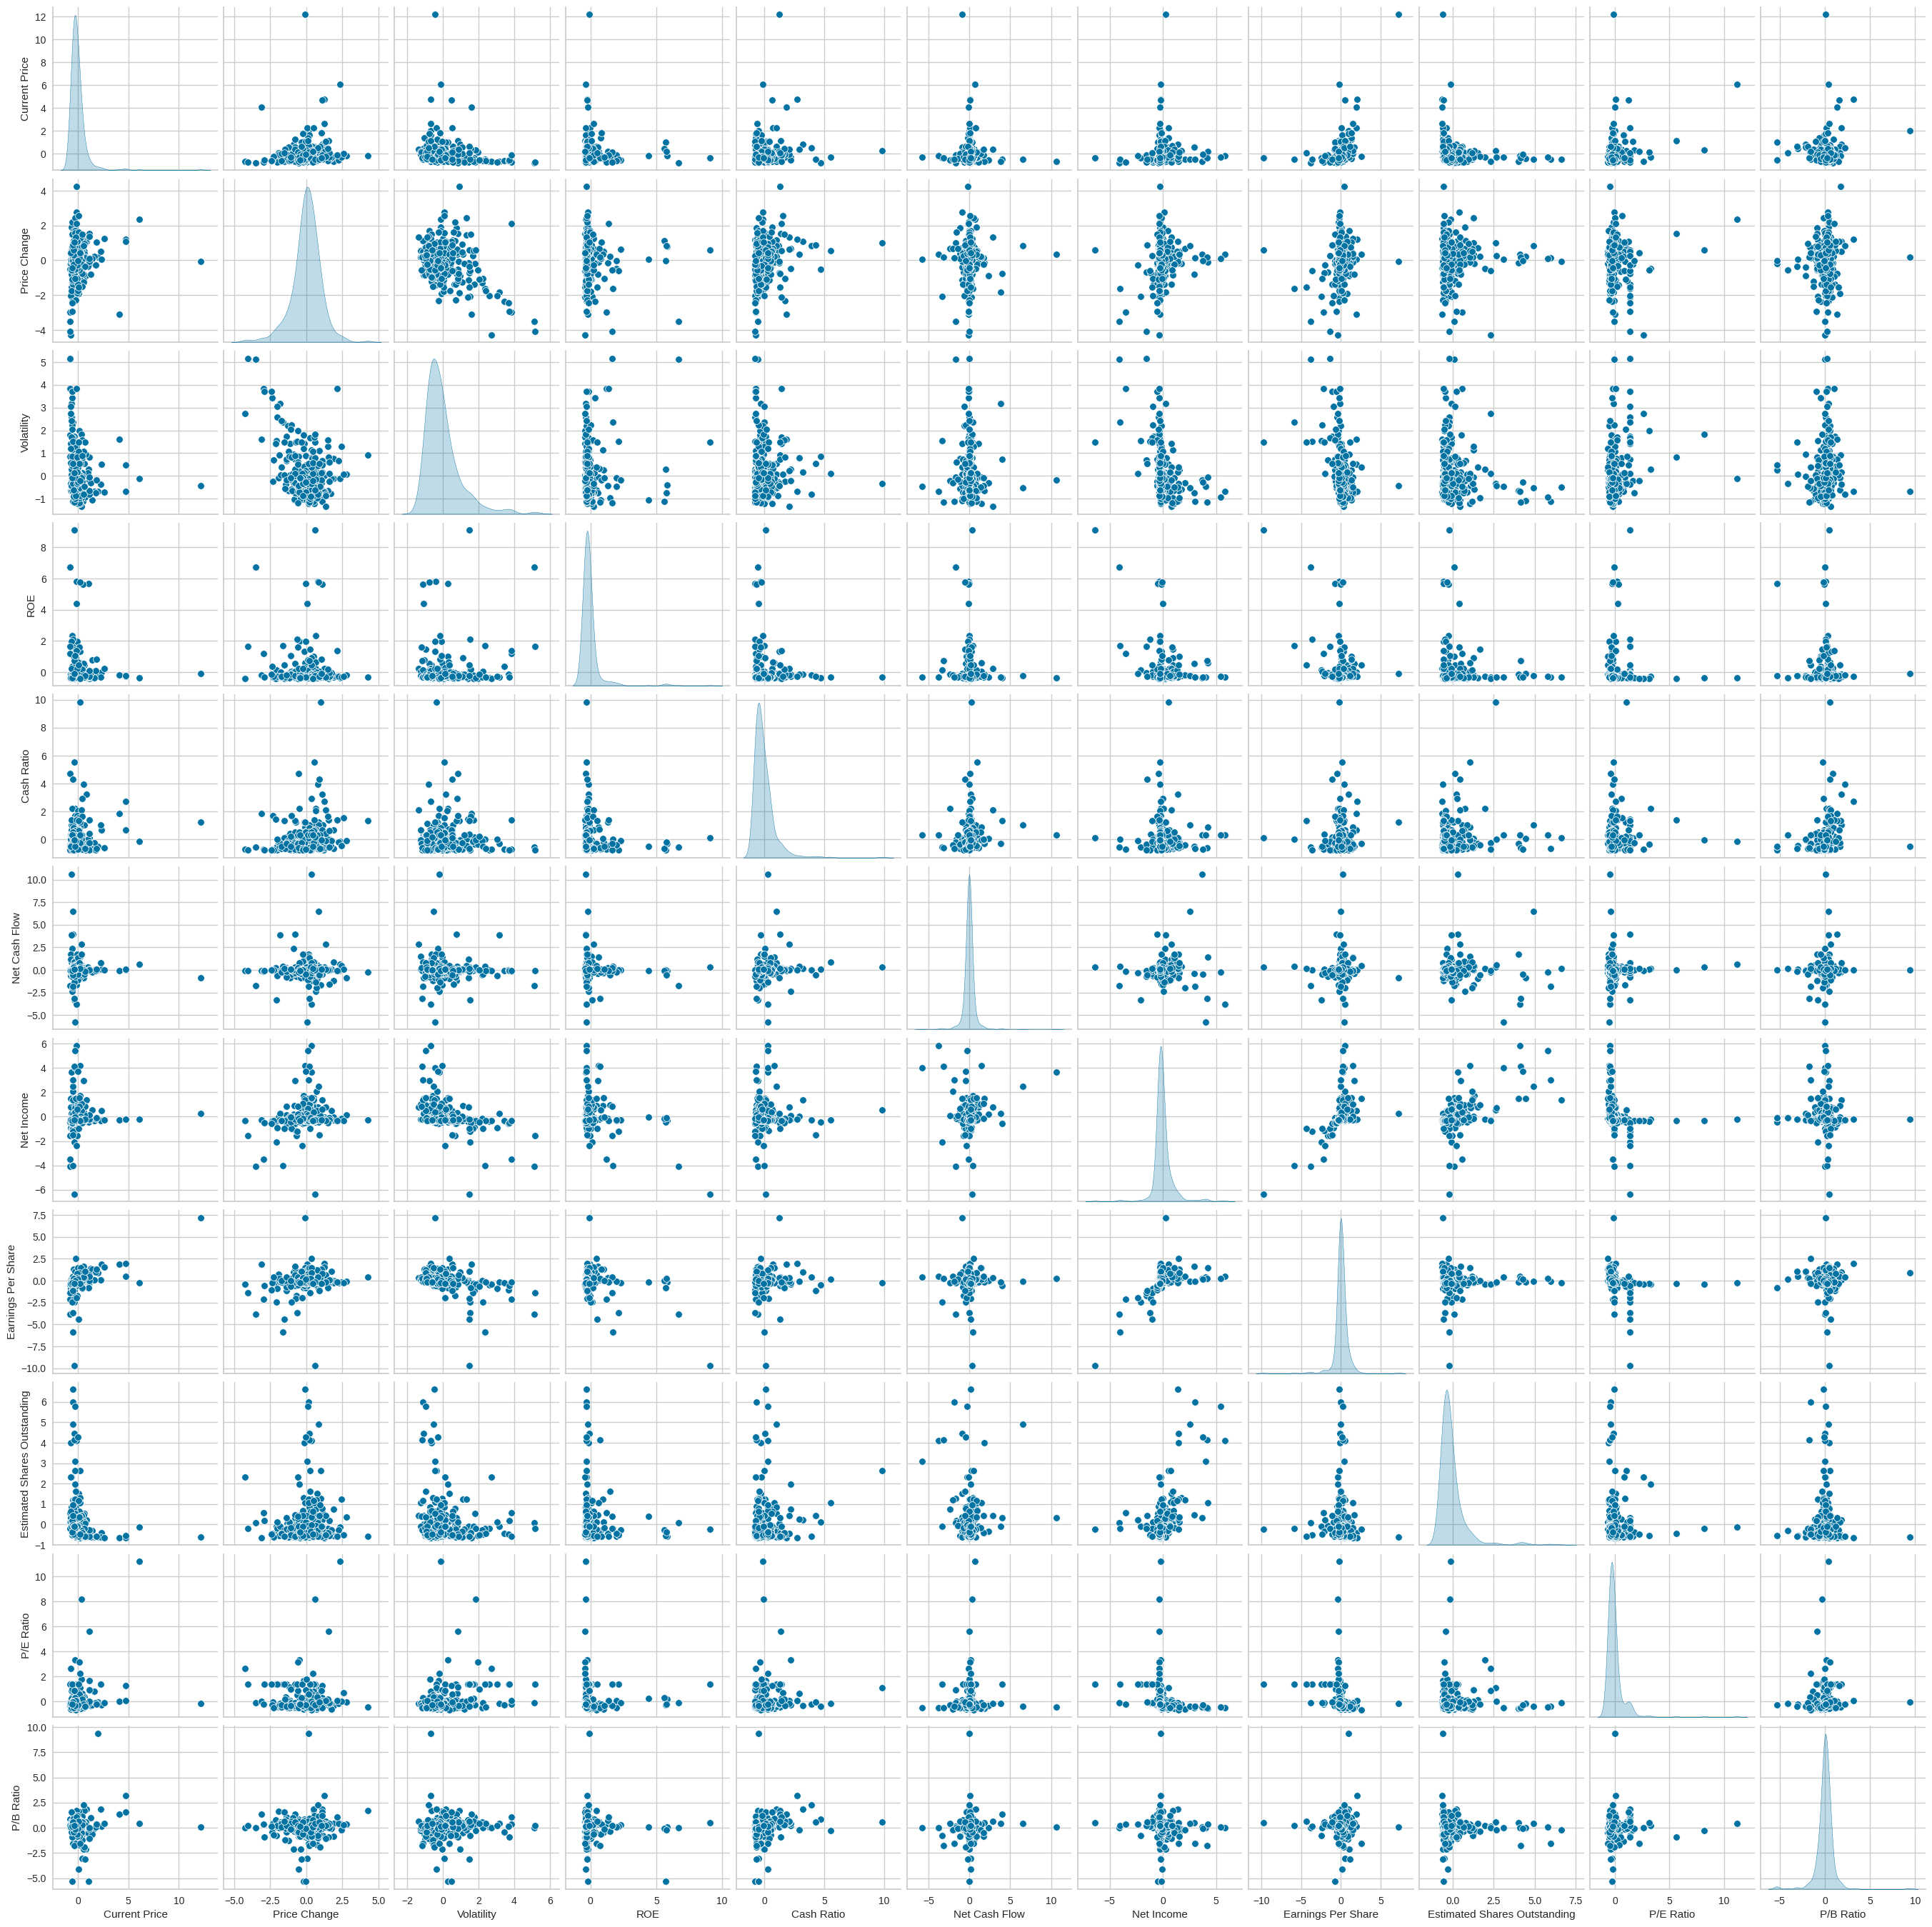

In [43]:
sns.pairplot(subset_scaled_df, diag_kind='kde');

* We observe that the distributions of the standardized data for P/E and P/B ratios exhibit multiple (4-6) modes, indicating the potential presence of at least 4 clusters in the data.

## K-means Clustering

### Let's use the elbow method to determine the optimal number of clusters for our dataset

The steps of the elbow method for determining the optimal number of clusters are as follows:

1. Define a range of cluster numbers: Determine the range of potential cluster numbers we want to evaluate. This range typically starts from a minimum of 2 clusters and increases incrementally based on our dataset size and domain knowledge.

2. Run clustering with different cluster numbers: Apply the chosen clustering algorithm to our preprocessed dataset using each cluster number in the defined range. Record the clustering performance metric for each run.

3. Calculate the clustering performance metric: Use a performance metric to assess the quality of the clustering results for each cluster number.

4. Plot the elbow curve: Create a line plot or a line chart where the x-axis represents the number of clusters, and the y-axis represents the corresponding clustering performance metric values. Each point on the plot represents the performance metric for a specific number of clusters.

5. Identify the elbow point: Analyze the elbow curve and look for the point where the change in the performance metric starts to level off. The elbow point is typically the number of clusters where the improvement in clustering performance diminishes significantly.

6. Determine the optimal number of clusters: Based on the elbow point, determine the optimal number of clusters for our dataset. This is usually the point where the performance improvement becomes less substantial and adding more clusters does not significantly improve the results.

**NB**: The elbow method provides a heuristic rather than an exact solution, and the interpretation of the elbow point is subjective. We need to validate the chosen number of clusters using other evaluation technique.

*We will add a polynomial trend to simplify finding an inflection point.*

Number of Clusters: 1, Average Distortion: 2.5425069919221697
Number of Clusters: 2, Average Distortion: 2.382318498894466
Number of Clusters: 3, Average Distortion: 2.2683105560042285
Number of Clusters: 4, Average Distortion: 2.1822426161442072
Number of Clusters: 5, Average Distortion: 2.139205926363256
Number of Clusters: 6, Average Distortion: 2.0737104927328227
Number of Clusters: 7, Average Distortion: 2.02273631956027
Number of Clusters: 8, Average Distortion: 1.9899408536298782
Number of Clusters: 9, Average Distortion: 1.9233883300130414


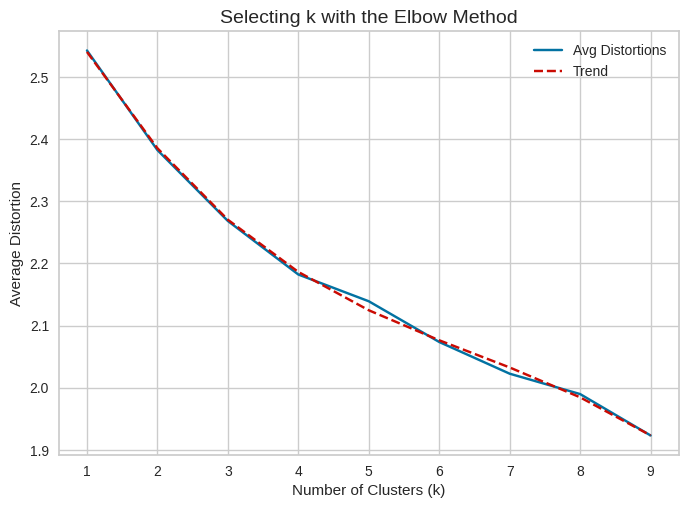

In [44]:
clusters = range(1, 10)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )
    meanDistortions.append(distortion)
    print(f'Number of Clusters: {k}, Average Distortion: {distortion}')

degree = 3  # Degree of the polynomial
X = np.array(clusters).reshape(-1, 1)
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X)
poly_model = LinearRegression()
poly_model.fit(X_poly, meanDistortions)
y_poly = poly_model.predict(X_poly)

plt.plot(clusters, meanDistortions, 'bx-', label='Avg Distortions')
plt.plot(clusters, y_poly, 'r--', label='Trend')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Distortion')
plt.title('Selecting k with the Elbow Method', fontsize=14)
plt.legend()
plt.show()

* **The appropriate value for $k$ from the elbow curve appears to be 4.**

### Let's use the elbow method with SSE as a performance metric

*The sum of squared distances (SSE) is computed using the inertia_ attribute of the fitted KMeans object and stored in the `sse` list.*

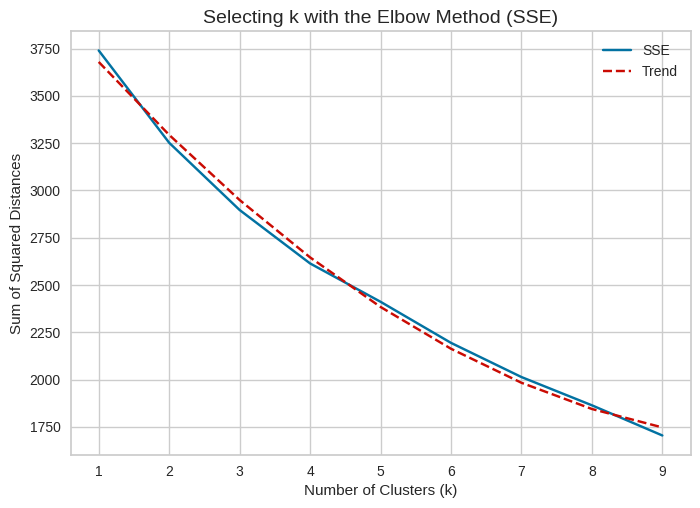

In [45]:
# Initialize an empty list to store the sum of squared distances
sse = []

# Perform K-means clustering for each value of k
for k in clusters:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(subset_scaled_df)
  sse.append(kmeans.inertia_)

degree = 2  # Degree of the polynomial
X = np.array(clusters).reshape(-1, 1)
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X)
poly_model = LinearRegression()
poly_model.fit(X_poly, sse)
y_poly = poly_model.predict(X_poly)


# Plot the elbow curve
plt.plot(clusters, sse, 'bx-', label='SSE')
plt.plot(clusters, y_poly, 'r--', label='Trend')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Selecting k with the Elbow Method (SSE)', fontsize=14)
plt.legend()
plt.show()


* **The appropriate value for $k$ from the elbow curve appears to be 4 or 5.**

### Let's check the silhouette scores

To determine the optimal number of clusters using the silhouette score, we will follow these steps:

1. Perform clustering on our dataset with different numbers of clusters. 
2. Calculate the silhouette score for each number of clusters. The silhouette score will be calculated for each data point in the dataset and then averaged.
3. Choose the number of clusters for which the silhouette score is maximum. This will be the optimal number of clusters that best describes our dataset.


For n_clusters = 2, silhouette score is 0.43969639509980457
For n_clusters = 3, silhouette score is 0.45797710447228496
For n_clusters = 4, silhouette score is 0.45017906939331087
For n_clusters = 5, silhouette score is 0.4599352800740646
For n_clusters = 6, silhouette score is 0.3985379248608659
For n_clusters = 7, silhouette score is 0.3868475076242907
For n_clusters = 8, silhouette score is 0.3886929719130642
For n_clusters = 9, silhouette score is 0.40581042332267614


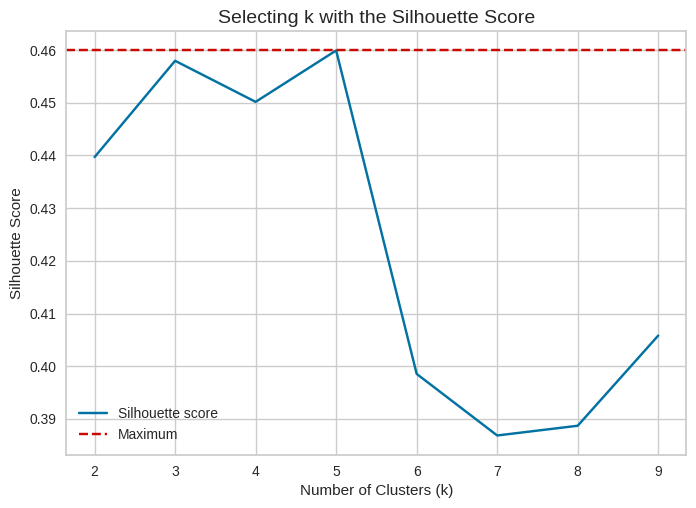

In [46]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    preds = clusterer.fit_predict((subset_scaled_df))
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

# Plot the silhouette curve
plt.plot(cluster_list, sil_score, label='Silhouette score')
plt.axhline(y=max(sil_score), color='r', linestyle='--', label='Maximum')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Selecting k with the Silhouette Score', fontsize=14)
plt.legend()
plt.show()

* **From the silhouette scores, it seems that 4 is a good value of k.**


**SilhouetteVisualizer** method

To interpret the SilhouetteVisualizer plot:

1. **Look for the clusters**: Each bar in the plot represents a data point, and the height of the bar indicates its silhouette coefficient. The silhouette coefficient measures how close a data point is to its own cluster compared to other clusters. The higher the silhouette coefficient, the better the clustering result.
2. **Evaluate cluster separation**: The bars are grouped by color, representing different clusters. Examine how well-separated the clusters are. Ideally, we want to see distinct, well-defined clusters with minimal overlap.
3. **Assess cluster quality**: Check the average silhouette score, which is represented by a dashed line in the plot. The average silhouette score is a measure of overall clustering quality. A higher score indicates better-defined clusters.
4. **Identify problematic clusters**: If we notice clusters with significantly lower silhouette coefficients or clusters that overlap heavily with other clusters, it may indicate potential issues with the clustering algorithm or data.

*By analyzing these aspects of the SilhouetteVisualizer plot, we can gain insights into the quality and separation of the clusters in your data.**

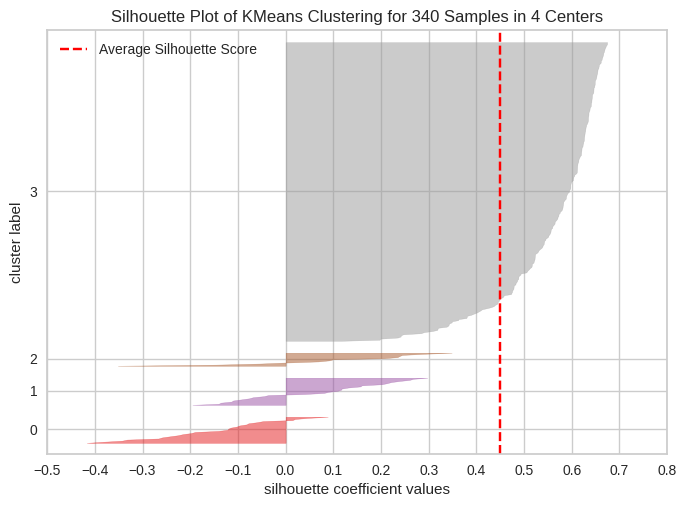

In [47]:
# Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=42))
visualizer.fit(subset_scaled_df)
visualizer.show();

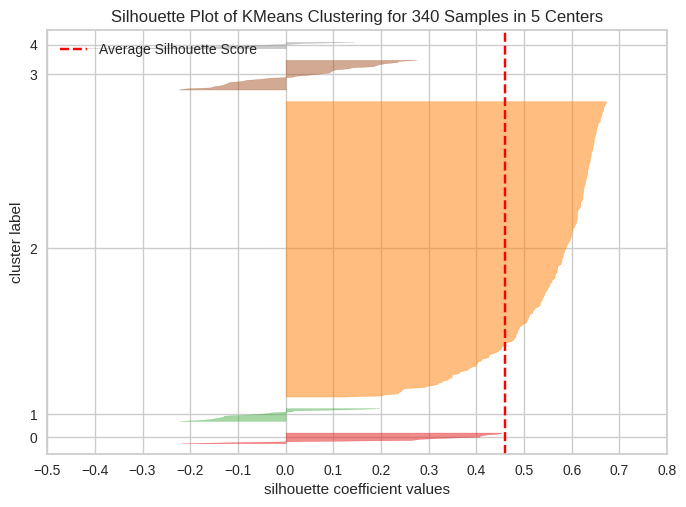

In [48]:
# Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=42))
visualizer.fit(subset_scaled_df)
visualizer.show();

* Based on the analysis using the SilhouetteVisualizer, we have chosen 4 clusters. 

>*This decision is based on the silhouette scores, which measure the cohesion and separation of data points within clusters. A higher silhouette score indicates that the data points are well-clustered and sufficiently separated from other clusters. In this case, the silhouette scores were highest when using 4 clusters, suggesting that this is the optimal number of clusters for the dataset.*

### Selecting final model


In [49]:
#Let's take 4 as the appropriate no. of clusters as the silhouette score is high enough and there is knick at 4 in the elbow curve.

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=4, random_state=42)

In [50]:
# adding kmeans cluster labels to the original dataframe
df["KM Clusters"] = kmeans.labels_

# adding kmeans cluster labels to the scaled dataframe
subset_scaled_df["KM Clusters"] = kmeans.labels_

### Cluster Profiling

In [51]:
km_cluster_profile = df.groupby("KM Clusters").mean()

In [52]:
km_cluster_profile['count'] = (
    df.groupby('KM Clusters')['Current Price'].count().values
)

In [53]:
# let's display cluster profiles
km_cluster_profile.style\
  .set_table_styles([{'selector': 'th',
                      'props': [('max-width', '50px')]}])\
  .highlight_max(color="lightgreen", axis=0)\
  .format('{:,.2f}')

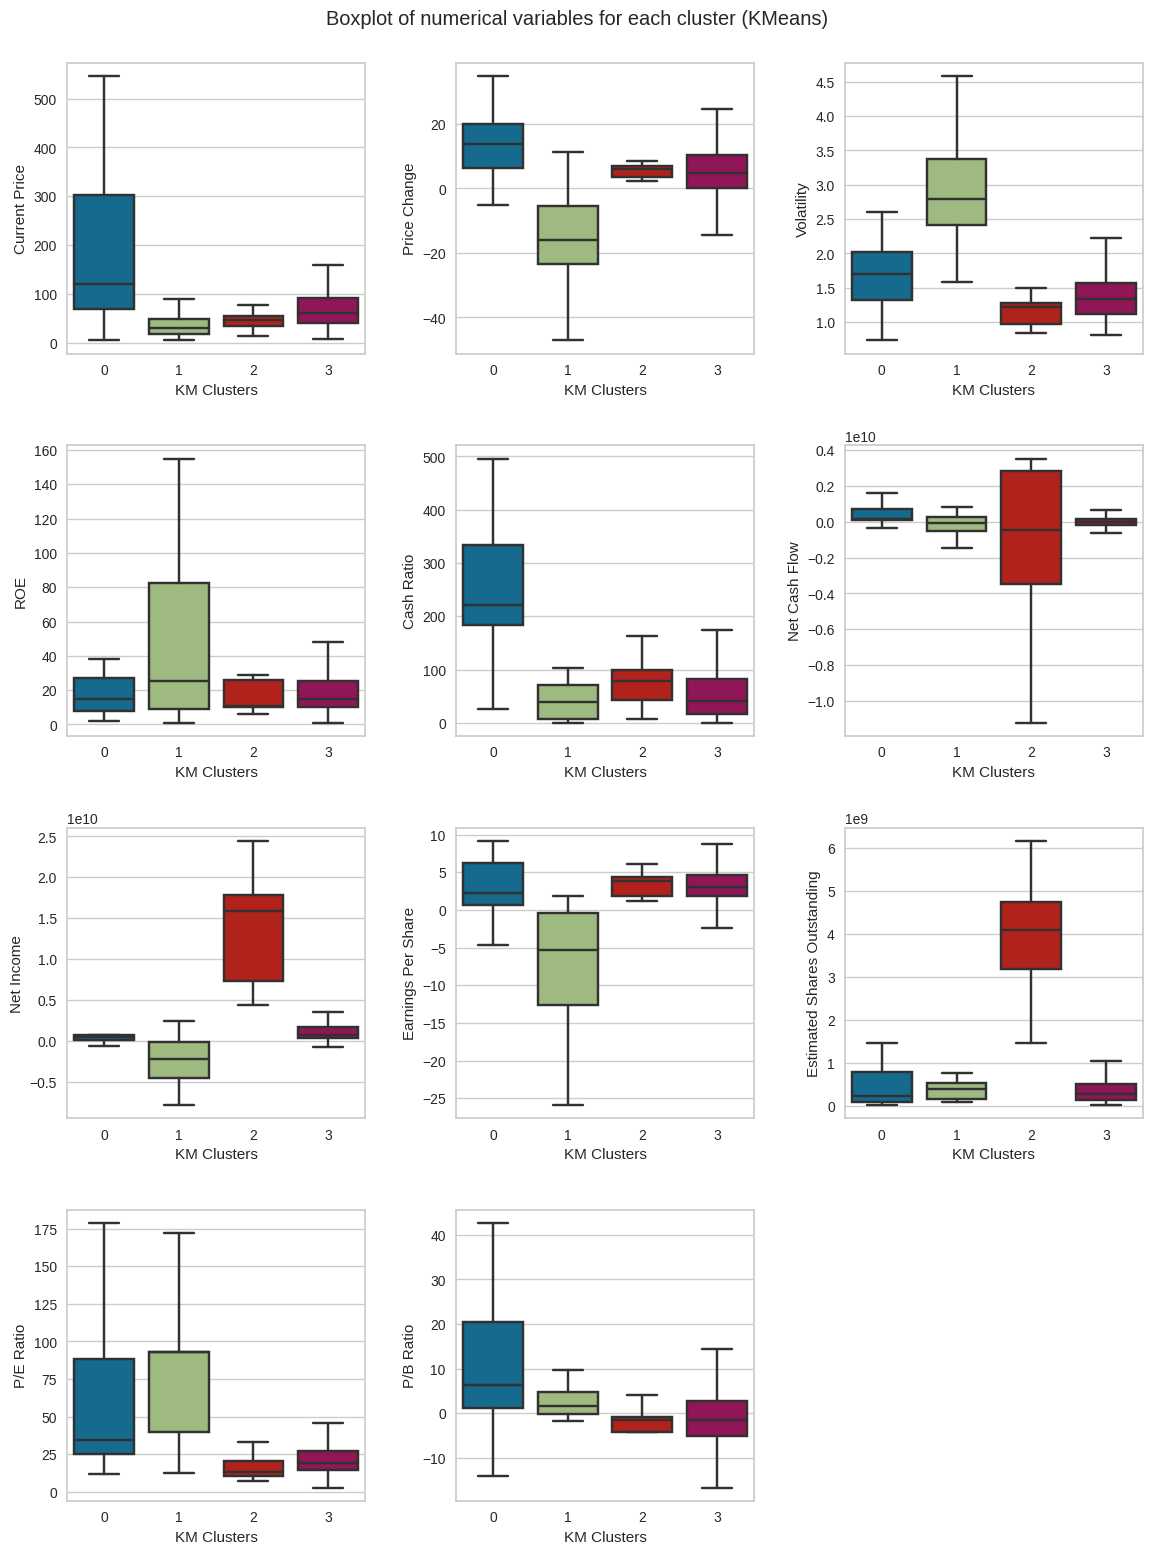

In [54]:
# Let's draw boxplots of numerical variables for each cluster
plt.figure(figsize=(12, 16))
plt.suptitle('Boxplot of numerical variables for each cluster (KMeans)')

for i, variable in enumerate(num_col):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(data=df, x='KM Clusters', y=variable, showfliers=False)

plt.tight_layout(pad=2);

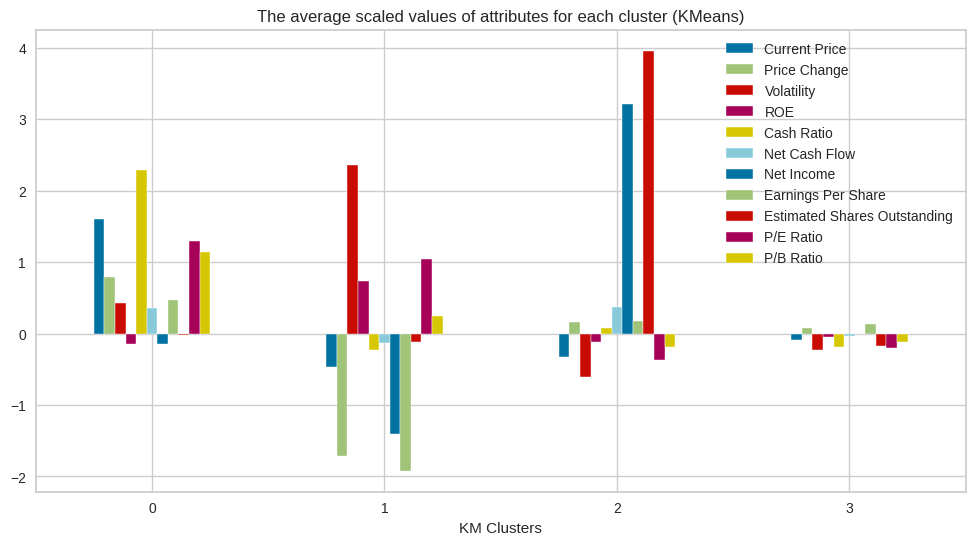

In [55]:
# Let's draw the average scaled values of attributes for each cluster
subset_scaled_df.groupby('KM Clusters').mean().plot.bar(figsize=(12, 6))
plt.xticks(rotation=0)
plt.title('The average scaled values of attributes for each cluster (KMeans)')
plt.show();

In [56]:
# The number of securities in each cluster by sector
print('The number of securities in each cluster by sectors:')
display(
    df.pivot_table(index='GICS Sector', columns='KM Clusters', values='Current Price', aggfunc='count')\
      .style.highlight_max(color = 'lightgreen', axis = 0)\
      .set_table_styles([{'selector': 'th',
                          'props': [('min-width', '50px')]}])\
      .format('{:.0f}', na_rep='--'));

The number of securities in each cluster by sectors:


In [57]:
# The percentage of securities in each cluster by sector
print('The percentage of securities in each cluster by sectors:')

tmp = df.pivot_table(index='GICS Sector', columns='KM Clusters', values='Current Price', aggfunc='count')

display((tmp / tmp.sum())\
      .style.highlight_max(color = 'lightgreen', axis = 0)\
      .set_table_styles([{'selector': 'th',
                          'props': [('min-width', '50px')]}])\
      .format('{:.0%}', na_rep='--'));

The percentage of securities in each cluster by sectors:


### Insights

The specific differences for each cluster, focusing on the aspects that set them apart from the other clusters.

**Cluster 0:**
* Number of seurities: 25
* Major Sector$^1$: Health Care (36%), followed by Consumer Discretionary and IT
* Significantly higher **Current Price** compared to other clusters.
* Relatively high **Cash Ratio**, indicating higher liquidity compared to other clusters.

**Cluster 1:**
* Number of seurities: 26
* Major Sector: Energy (85%)
* Significantly lower **Current Price** compared to other clusters.
* A negative **Price Change** on average within this cluster.
* The lowest **Cash Ratio** compared to other clusters, indicates a relatively lower level of liquidity in terms of cash reserves.
* Negative **Net Income** suggests that on average, the expenses exceed the revenues for the companies in this cluster.
* Relatively high **Volatility** and **P/E Ratio**, suggesting higher price fluctuations and valuation compared to other clusters.

**Cluster 2:**
* Number of seurities: 13
* Major Sector: Financials (31%)
* Relatively low **Volatility** compared to other clusters.
* Higher **Net income** and **Estimated Shares Outstanding** compared to other clusters. 
* Negative P/B ratio, suggesting potential undervaluation compared to other clusters.

**Cluster 3:**
* Number of seurities: 276
* Major Sector: Industrials (19)
* The largest cluster encompassing more than 80% of the securities.
clusters.
* Relatively lower **Cash Ratio** compared to some clusters.
* Negative **P/B ratio**, suggesting potential undervaluation compared to other clusters.
---
$^1$ *The major sectors assigned to each cluster are based on the number of securities in each sector within the cluster.*

## Hierarchical Clustering

### Checking Cophenetic Correlation


In [58]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(f'Cophenetic correlation for {dm.capitalize()} distance and {lm} linkage is {c:.4f}.')
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.9284.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8566.
Cophenetic correlation for Euclidean distance and average linkage is 0.9467.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.7481.
Cophenetic correlation for Chebyshev distance and single linkage is 0.9157.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8229.
Cophenetic correlation for Chebyshev distance and average linkage is 0.9377.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.9156.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.9319.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.7325.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.9409.
Cophenetic correlation for Mahalanobis distance and weighted linkage is 0.9094.
Cophenetic correlation for Cityblock distance and single linkage 

In [59]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(f'Highest cophenetic correlation is {high_cophenet_corr:.4f}, which is obtained with `{high_dm_lm[0].capitalize()}` distance and `{high_dm_lm[1]}` linkage.')

Highest cophenetic correlation is 0.9467, which is obtained with `Euclidean` distance and `average` linkage.


### Let's explore different linkage methods with `Euclidean` distance only

In [60]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
    print(f'Cophenetic correlation for `{lm}` linkage is {c:.4f}.')
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for `single` linkage is 0.9284.
Cophenetic correlation for `complete` linkage is 0.8566.
Cophenetic correlation for `average` linkage is 0.9467.
Cophenetic correlation for `centroid` linkage is 0.9493.
Cophenetic correlation for `ward` linkage is 0.7433.
Cophenetic correlation for `weighted` linkage is 0.7481.


In [61]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(f'Highest cophenetic correlation is {high_cophenet_corr:.4f}, which is obtained with `{high_dm_lm[1]}` linkage.')

Highest cophenetic correlation is 0.9493, which is obtained with `centroid` linkage.


* We see that the cophenetic correlation is maximum with **Euclidean** distance and **centroid** linkage.

## Checking Dendrograms

Dendrogram is a graphical representation of a tree-like structure used in hierarchical clustering. It visualizes the relationships between objects or groups of objects.

Reading a dendrogram requires some understanding of its structure and the values on the axes. Here are the key elements to consider when reading a dendrogram:

1. Y-axis: It represents a measure of distance or similarity between objects or groups. The lower the fusion on the Y-axis, the more similar the objects or groups are considered to be.

2. X-axis: It represents a set of objects or groups of objects. Each branch on the X-axis represents an individual object or group of objects.

3. Connecting lines: The connecting lines in a dendrogram represent the merging of objects or groups. The height of the line on the Y-axis indicates the distance or similarity between the objects or groups being merged. Higher lines correspond to the merging of objects or groups at higher levels of the hierarchy.

4. Horizontal line: The horizontal line intersecting the connecting lines defines a threshold for merging. The line connects two connecting lines that do not exceed this threshold. You can choose a slicing level perpendicular to this horizontal line to determine which groups are merged into clusters.

5. The colors represent different clusters.

Determining an appropriate number of clusters from a dendrogram can be subjective and dependent on the specific problem or context. 

* Height or Distance Threshold: One method is to set a height or distance threshold on the dendrogram and select the number of clusters based on where the horizontal line intersects the dendrogram. This threshold should be chosen based on the desired level of granularity in the clusters. Clusters formed below the threshold will be merged, and those above the threshold will be treated as separate clusters.

### Let's see the dendrograms for the different linkage methods.

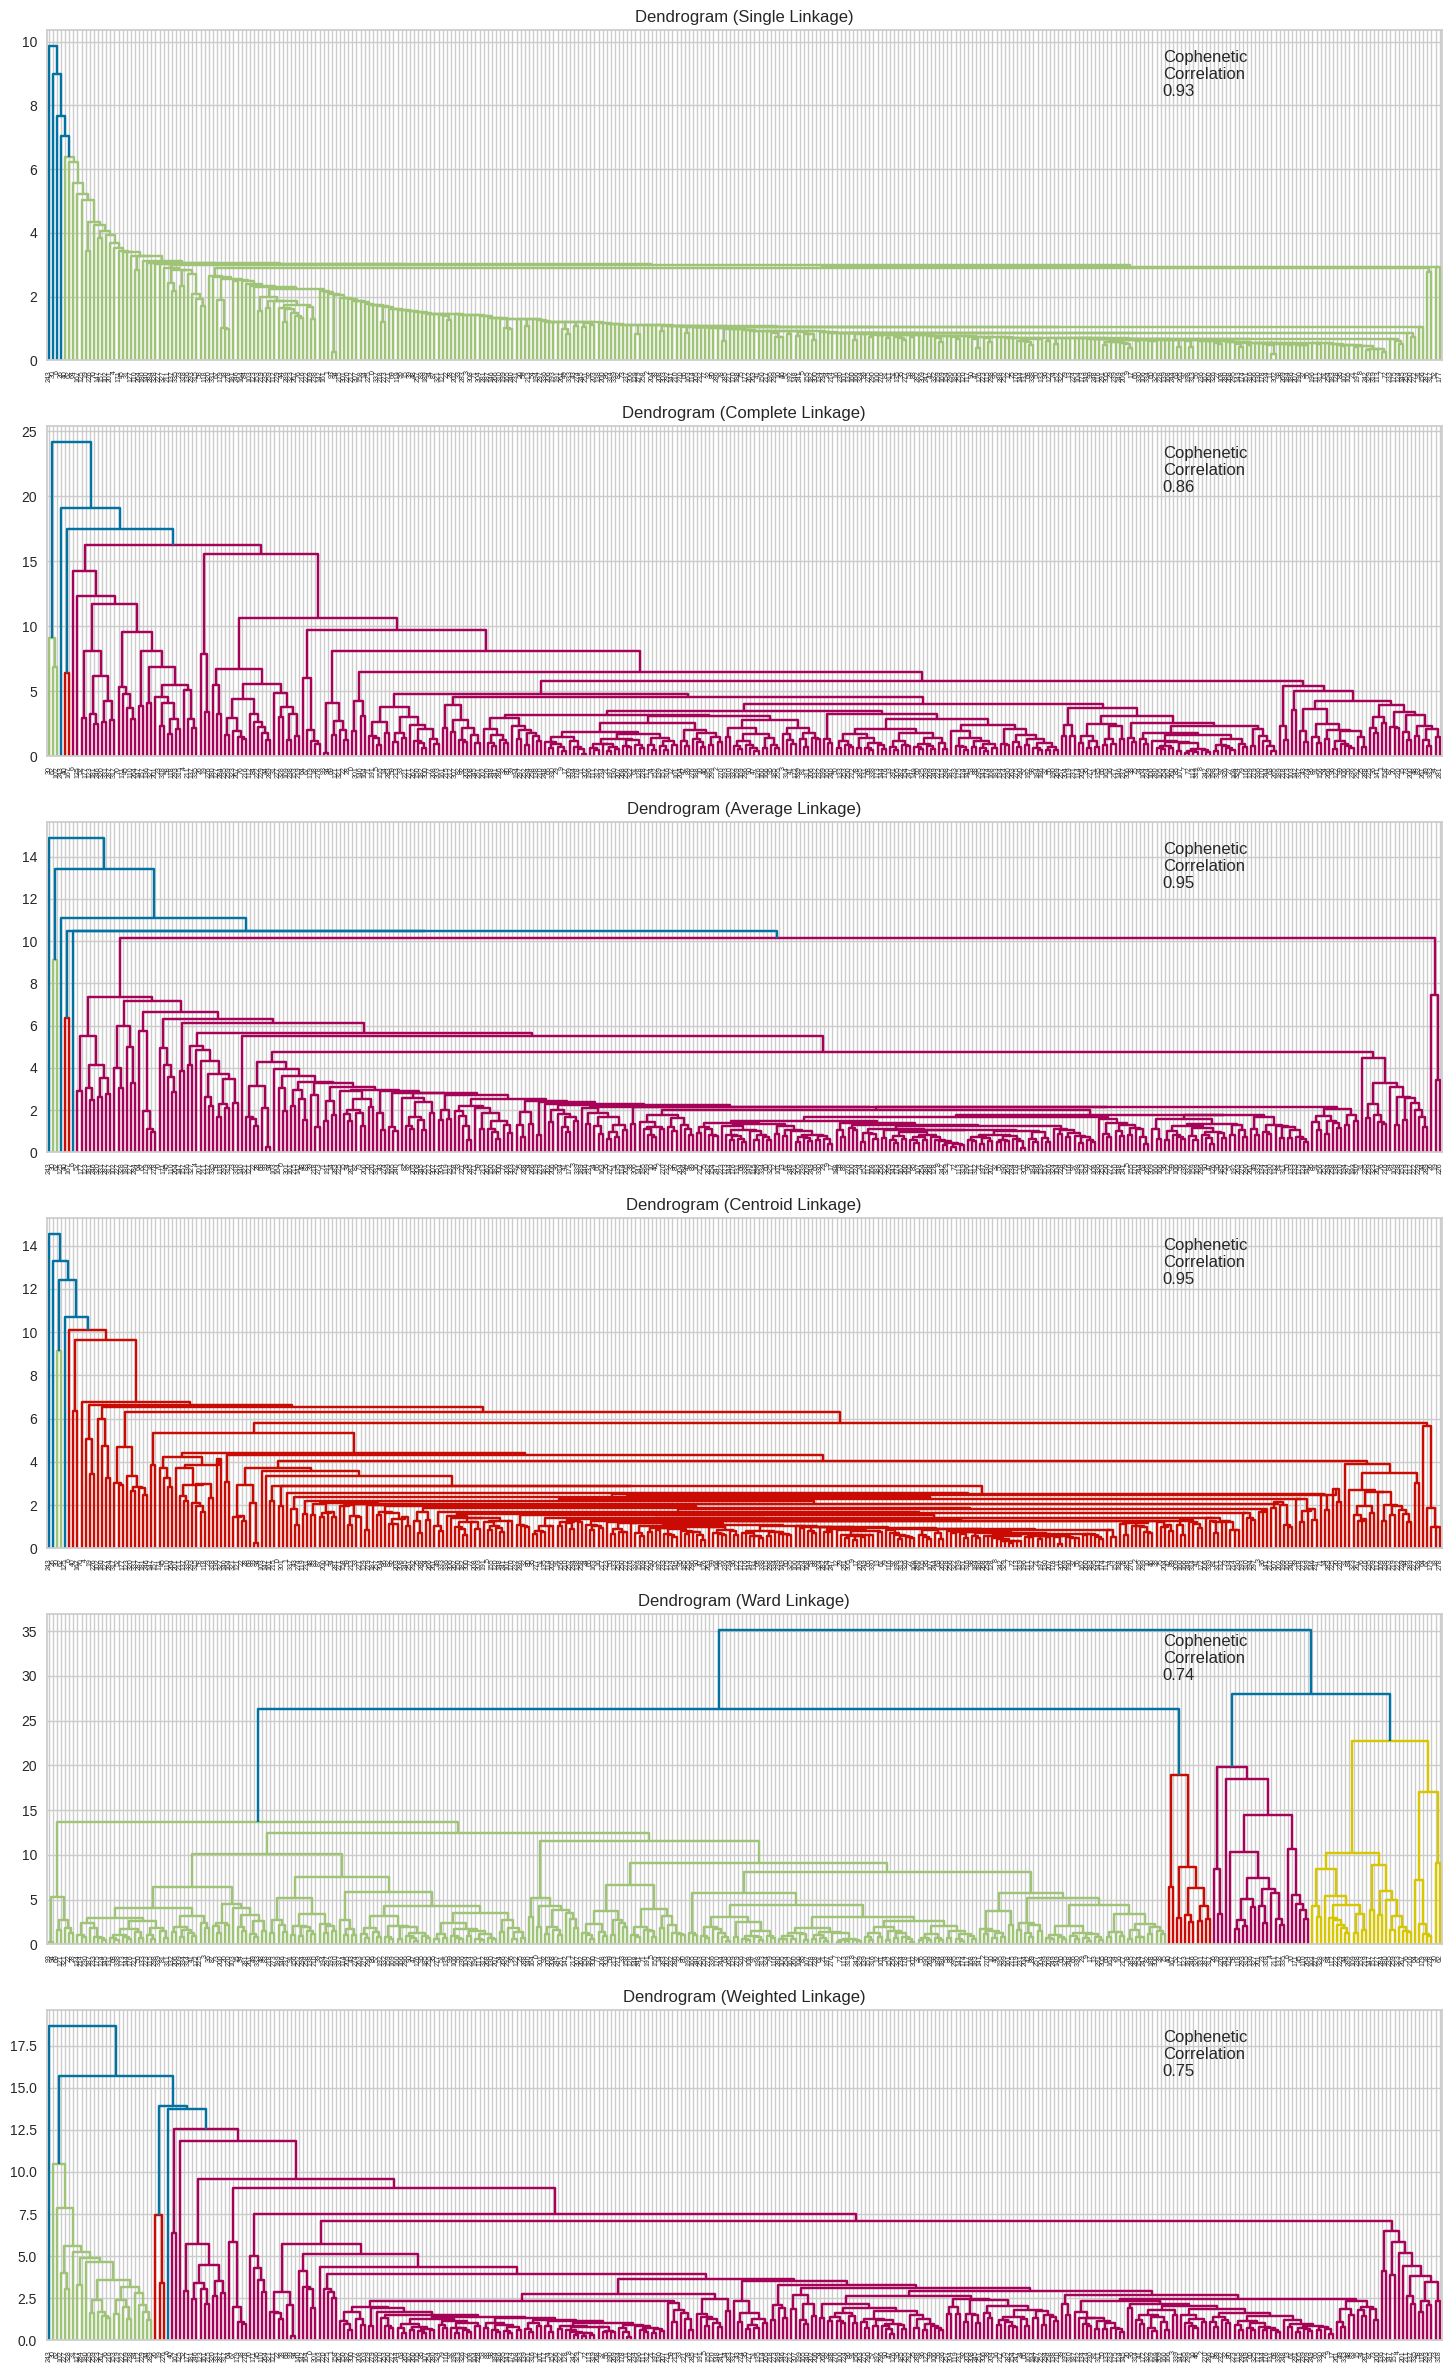

In [62]:
# list of linkage methods
linkage_methods = ['single', 'complete', 'average', 'centroid', 'ward', 'weighted']

# lists to save results of cophenetic correlation calculation
compare_cols = ['Linkage', 'Cophenetic Coefficient']

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(18, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric='euclidean', method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f'Dendrogram ({method.capitalize()} Linkage)')

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(f'Cophenetic\nCorrelation\n{coph_corr:0.2f}',
                    (0.80, 0.80), xycoords='axes fraction');
                    

**Observations:**

- The cophenetic correlation is highest for centroid linkage method.
- 4 appears to be the appropriate number of clusters from the dendrogram for centroid linkage.

### Creating Model using sklearn

In [63]:
HCmodel = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="average")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(affinity='euclidean', linkage='average', n_clusters=4)

In [64]:
subset_scaled_df["HC Clusters"] = HCmodel.labels_
df["HC Clusters"] = HCmodel.labels_

### Cluster Profiling

In [65]:
cluster_profile = df.groupby('HC Clusters').mean()

In [66]:
cluster_profile['count'] = (df.groupby('HC Clusters')['Current Price'].count().values)

In [67]:
# let's see the names of the companies in each cluster
for cl in df['HC Clusters'].unique():
  print(f'In cluster `{cl}`, the following countries are present:')
  if df[df['HC Clusters'] == cl]['Security'].nunique()>10:
    print(df[df['HC Clusters'] == cl]['Ticker Symbol'].unique())
  else:
    print(df[df['HC Clusters'] == cl]['Security'].unique())
  print()

In cluster `0`, the following countries are present:
['AAL' 'ABBV' 'ABT' 'ADBE' 'ADI' 'ADM' 'ADS' 'AEE' 'AEP' 'AFL' 'AIG' 'AIV'
 'AIZ' 'AJG' 'AKAM' 'ALB' 'ALK' 'ALL' 'ALLE' 'ALXN' 'AMAT' 'AME' 'AMG'
 'AMGN' 'AMP' 'AMT' 'AMZN' 'AN' 'ANTM' 'AON' 'APC' 'APH' 'ARNC' 'ATVI'
 'AVB' 'AVGO' 'AWK' 'AXP' 'BA' 'BAC' 'BAX' 'BBT' 'BCR' 'BHI' 'BIIB' 'BK'
 'BLL' 'BMY' 'BSX' 'BWA' 'BXP' 'C' 'CAT' 'CB' 'CBG' 'CCI' 'CCL' 'CELG'
 'CF' 'CFG' 'CHD' 'CHRW' 'CHTR' 'CI' 'CINF' 'CL' 'CMA' 'CME' 'CMG' 'CMI'
 'CMS' 'CNC' 'CNP' 'COF' 'COG' 'COO' 'CSX' 'CTL' 'CTSH' 'CTXS' 'CVS' 'CVX'
 'CXO' 'D' 'DAL' 'DD' 'DE' 'DFS' 'DGX' 'DHR' 'DIS' 'DISCA' 'DISCK' 'DLPH'
 'DLR' 'DNB' 'DOV' 'DPS' 'DUK' 'DVA' 'DVN' 'EBAY' 'ECL' 'ED' 'EFX' 'EIX'
 'EMN' 'EOG' 'EQIX' 'EQR' 'EQT' 'ES' 'ESS' 'ETFC' 'ETN' 'ETR' 'EW' 'EXC'
 'EXPD' 'EXPE' 'EXR' 'F' 'FAST' 'FBHS' 'FCX' 'FE' 'FIS' 'FISV' 'FLIR'
 'FLR' 'FLS' 'FMC' 'FRT' 'FSLR' 'FTR' 'GD' 'GGP' 'GILD' 'GLW' 'GM' 'GPC'
 'GRMN' 'GT' 'GWW' 'HAL' 'HAS' 'HBAN' 'HCA' 'HCN' 'HCP' 'HES' 'HIG' 'HOG'
 

**Observations:**

* We see that there are 2 clusters of one company, 1 cluster of two companies, and all the other companies are grouped into another cluster. This clustering does not look good as the clusters do not have enough variability.

* Let us try using Ward linkage as it has more distinct and separated clusters (as seen from it's dendrogram before). 

* 4 appears to be the appropriate number of clusters from the dendrogram for Ward linkage.

### Creating Final Model

In [68]:
HCmodel = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="ward")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(affinity='euclidean', n_clusters=4)

In [69]:
subset_scaled_df['HC Clusters'] = HCmodel.labels_
df['HC Clusters'] = HCmodel.labels_

### Cluster Profiling

In [70]:
hc_cluster_profile = df.drop('KM Clusters', axis=1).groupby("HC Clusters").mean()

In [71]:
hc_cluster_profile['count'] = (
    df.groupby('HC Clusters')['Current Price'].count().values
)

In [72]:
# let's display cluster profiles
hc_cluster_profile.style\
  .set_table_styles([{'selector': 'th',
                      'props': [('max-width', '50px')]}])\
  .highlight_max(color="lightgreen", axis=0)\
  .format('{:,.2f}')

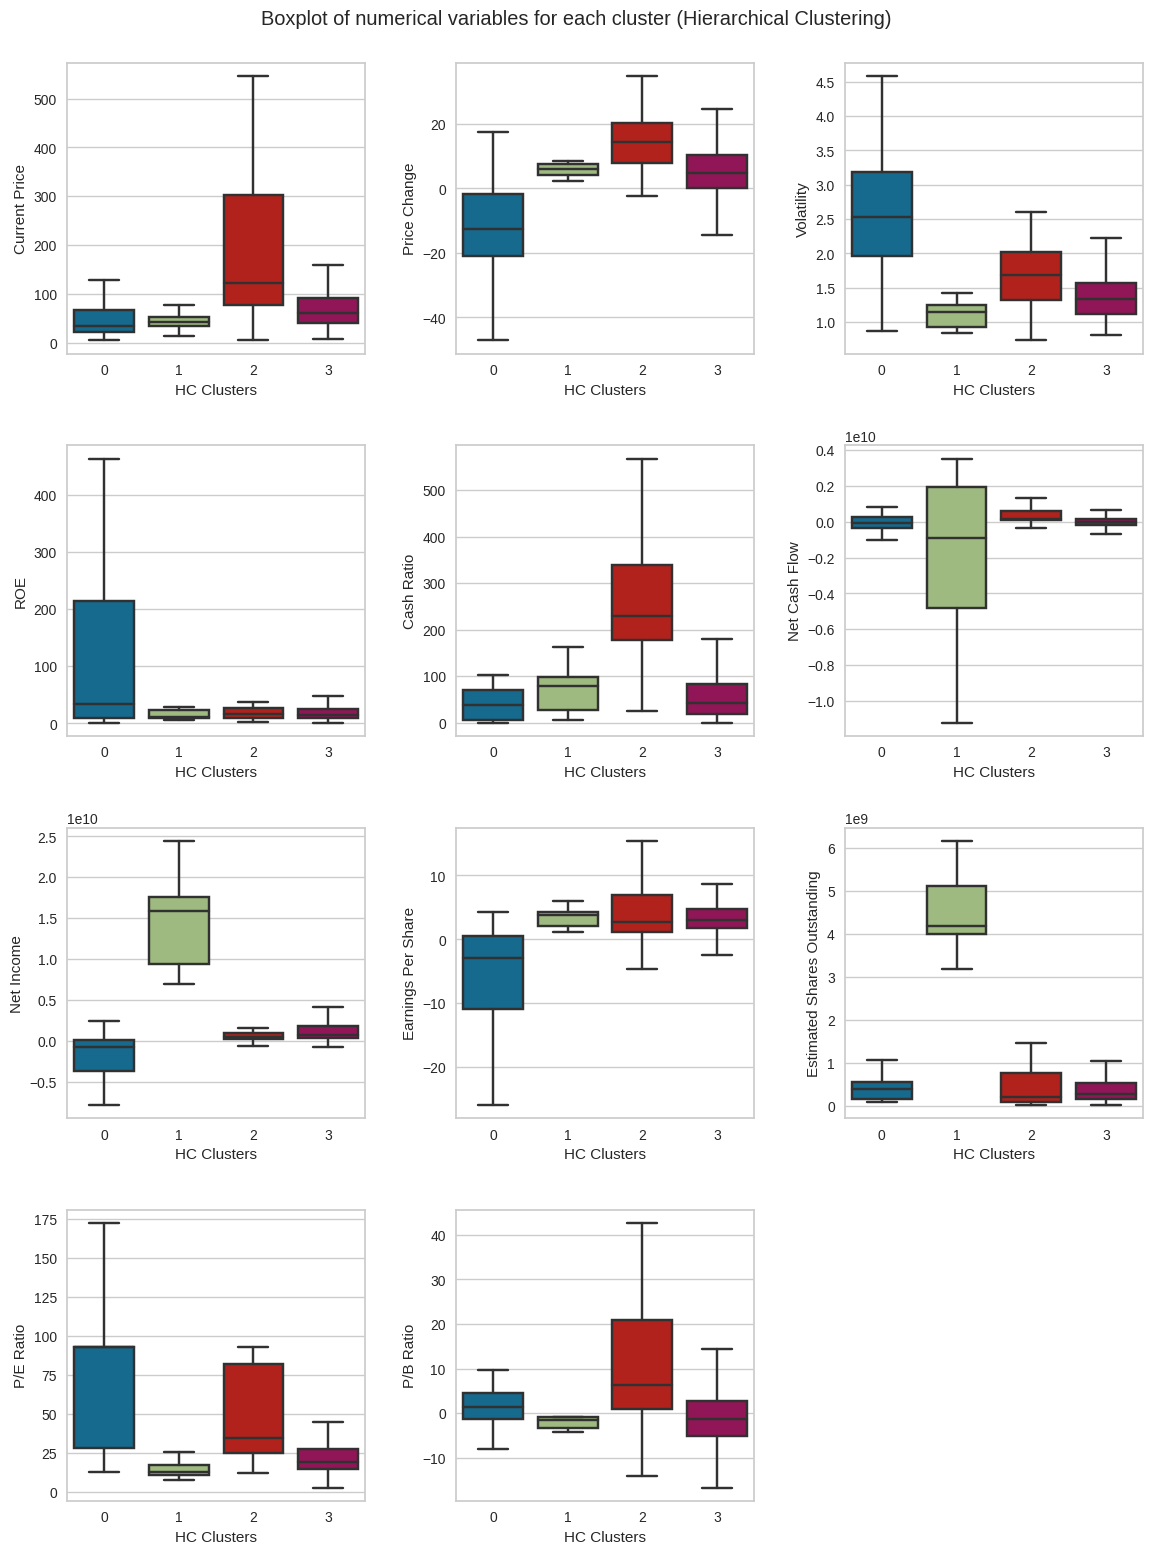

In [73]:
# Let's draw boxplots of numerical variables for each cluster
plt.figure(figsize=(12, 16))
plt.suptitle('Boxplot of numerical variables for each cluster (Hierarchical Clustering)')

for i, variable in enumerate(num_col):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(data=df, x='HC Clusters', y=variable, showfliers=False)

plt.tight_layout(pad=2);

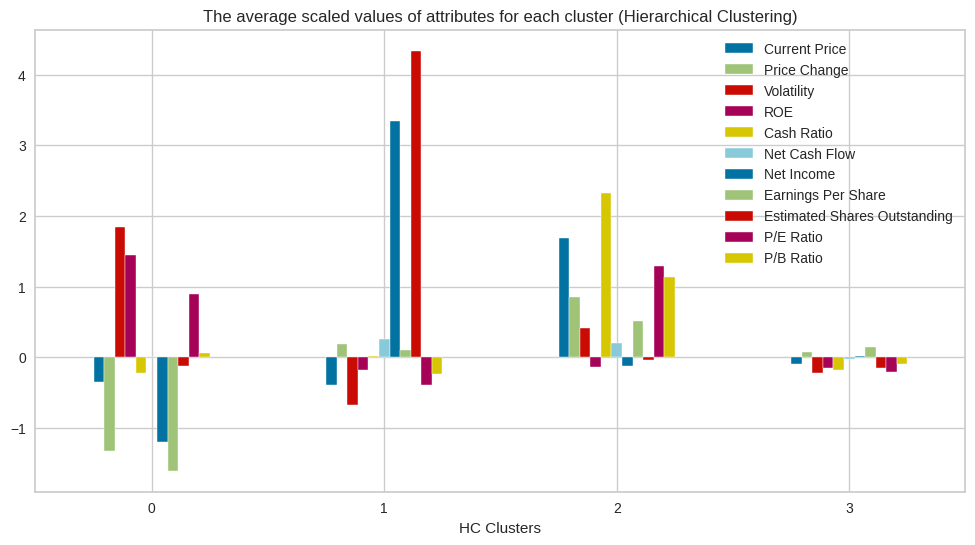

In [74]:
# Let's draw the average scaled values of attributes for each cluster
subset_scaled_df.drop('KM Clusters', axis=1).groupby('HC Clusters').mean().plot.bar(figsize=(12, 6))
plt.xticks(rotation=0)
plt.title('The average scaled values of attributes for each cluster (Hierarchical Clustering)')
plt.show();

In [75]:
# The number of securities in each cluster by sector
print('The number of securities in each cluster by sectors:')
display(
    df.pivot_table(index='GICS Sector', columns='HC Clusters', values='Current Price', aggfunc='count')\
      .style.highlight_max(color = 'lightgreen', axis = 0)\
      .set_table_styles([{'selector': 'th',
                          'props': [('min-width', '50px')]}])\
      .format('{:.0f}', na_rep='--'));

The number of securities in each cluster by sectors:


In [76]:
# The percentage of securities in each cluster by sector
print('The percentage of securities in each cluster by sectors:')

tmp = df.pivot_table(index='GICS Sector', columns='HC Clusters', values='Current Price', aggfunc='count')

display((tmp / tmp.sum())\
      .style.highlight_max(color = 'lightgreen', axis = 0)\
      .set_table_styles([{'selector': 'th',
                          'props': [('min-width', '50px')]}])\
      .format('{:.0%}', na_rep='--'));

The percentage of securities in each cluster by sectors:


* The results closely align with those observed in K-Means clustering.

### Insights

The specific differences for each cluster, focusing on the aspects that set them apart from the other clusters.

**Cluster 0:**
* Number of securities: 32
* Major Sector$^1$: Energy (72%)
* This cluster has a significantly lower **Current Price** (\$46.56) compared to the other clusters. This cluster also shows a negative **Price Change** (-11.80%) on average. It has a relatively high **Volatility** (2.62) compared to the other clusters, suggesting more price fluctuations. The **Cash Ratio** is 50.25%, indicating a moderate liquidity level. Negative **Net Income** (-\$3.2B) suggests that on average, the expenses exceed the revenues for the companies in this cluster. It also has a negative **P/B ratio** (-0.78), suggesting potential undervaluation compared to other clusters.

**Cluster 1:**
* Number of securities: 11
* Major Sector: Financials (36%)
* This cluster shows a **Current Price** of \$42.85 and a positive **Price Change** (6.27%) on average. The **Cash Ratio** is higher at 71.45%, indicating better liquidity. It also reports positive **Net Income** (\$14B), which shows the companies in this cluster, on average, are profitable. However, it has a negative **P/B ratio** (-4.92), suggesting potential undervaluation compared to other clusters.

**Cluster 2:**
* Number of securities: 24
* Major Sector: Health Care (38%)
* This cluster reports the highest **Current Price** (\$246.57) and a positive **Price Change** (14.28%) on average. It also shows relatively low **Volatility** (1.77) compared to other clusters. It has the highest **Cash Ratio** (279.92%) among all clusters, suggesting high liquidity. The **Net Income** is also positive (\$1B), indicating profitability. Contrary to other clusters, this one has a positive **P/B ratio** (14.08), suggesting potential overvaluation compared to other clusters.

**Cluster 3:**

* Number of securities: 273
* Major Sector: Industrials (19%)
* This cluster is the largest and has a **Current Price** of \$71.85. It shows a positive **Price Change** (4.95%) on average and moderate **Volatility** (1.39). The **Cash Ratio** (53.83%) is slightly higher than that of `Cluster 0` but lower than `Clusters 1` and `Cluster 2`. The **Net Income** is positive (\$1.6B), which means the companies in this cluster are, on average, profitable. This cluster also has a negative **P/B ratio** (-3.09), suggesting potential undervaluation compared to other clusters.

---
$^1$ *The major sectors assigned to each cluster are based on the number of securities in each sector within the cluster.*

## K-means vs Hierarchical Clustering

In [77]:
df.pivot_table(index='KM Clusters', columns='HC Clusters', values='Current Price', aggfunc='count')\
  .style.highlight_max(color = 'lightgreen', axis = 0)\
  .set_table_styles([{'selector': 'th',
                          'props': [('min-width', '50px')]}])\
  .format('{:.0f}', na_rep='--')

Despite minor discrepancies, the classifications derived from hierarchical clustering, using Euclidean distance and Ward linkage, align closely with those generated via K-Means clustering.

* `Cluster 0` from K-Means clustering aligns closely with `Cluster 2` from Hierarchical clustering, with the sole exception of `Halliburton Co.`, which remains in `Cluster 0` across both methods.
* `Cluster 1` from K-Means clustering precisely matches `Cluster 0` from Hierarchical clustering.
* `Cluster 2` from K-Means clustering largely aligns with `Cluster 1` from Hierarchical clustering, except for `Gilead Sciences` and `Merck & Co.`, both within the `Health Care` sector, which transition to `Cluster 3`.
* `Cluster 3` from K-Means clustering mostly corresponds with `Cluster 3` from Hierarchical clustering, notwithstanding the five exceptions that migrate to `Cluster 0`.

**Observations:**
* **Execution Time**: K-Means is generally faster and more scalable than hierarchical clustering, which is particularly relevant for larger datasets. However, in this instance, we only have 340 rows, so the execution time is comparable.

* **Distinctness of Clusters**: Both the K-Means and hierarchical clustering methods appear to provide distinct clusters. In our case they are  very similar.

* **Number of Similar Observations**: Both clustering methods have a high degree of overlap with 98% (332 out of 340) securities clustered similarly. This implies that both methods are consistent with the majority of securities.

* **Optimal Number of Clusters**: Both methods have led to a similar number of clusters (K-means resulted in 4 clusters, and hierarchical clustering in 4). Given the high degree of overlap, it suggests that the number of clusters is likely representative of the underlying data structure.

* **Cluster Profiles**: The given data indicates that the cluster profiles between the two methods align reasonably well, albeit with some differences.
For instance, a significant difference is observed in the **Net Cash Flow** of specific clusters between the two methods. These differences could result from the specific nuances that each algorithm identifies.
  * A prime example of this is `S&P Global, Inc.` It migrated from `Cluster 3 (KM)` to `Cluster 0 (HC)` (instead of `Cluster 3 (HC)`), carrying a negative Net Cash Flow of \$1B, thus altering the average values.

*Comparing and contrasting these aspects of the two clustering methods can provide a more comprehensive understanding of their strengths and limitations, and inform which technique might be most appropriate for future analyses of similar data.*

### Risk Analysis

**Cluster «Energy»$^1$: 1-KM / 0-HC:**
* This cluster appears to be the **highest risk**, primarily due to the substantial negative price change and high volatility. In addition, the negative net income indicates potential financial instability within these securities.
* This cluster appears to have higher risk due to a significant **negative price change** and **high volatility**. However, its Cash Ratio is relatively moderate, indicating some level of liquidity. Nevertheless, the negative net income suggests operational issues within these securities. A higher return on equity (ROE) could imply higher profitability, but combined with other factors, this cluster appears risky.
  
**Cluster «Industrials»: 3-KM / 3-HC:**
* This is the second **highest risk** cluster, given its moderate volatility and negative P/B ratio. Despite a positive price change and net income, these risk factors might overshadow the potential benefits.
* This is the largest cluster and shows a positive price change, though with slightly higher volatility than Clusters «Financials» and «Health Care». The Cash Ratio is moderate, but the Net Income is positive and high. This cluster seems to have a balance of risk and reward, but the negative P/B ratio could suggest potential undervaluation. The moderate P/E ratio also implies a reasonable market valuation.

**Cluster «Health Care»: 0-KM / 2-HC:**
* This cluster carries **moderate risk**. Although it has high current price and a positive price change, it also has a relatively high P/E Ratio which could suggest a higher market valuation and therefore higher risk. However, the high Cash Ratio and positive P/B Ratio might mitigate some risk factors.
* This cluster exhibits positive price change and moderate volatility. A high Cash Ratio shows excellent liquidity. However, the higher P/E Ratio could suggest a higher market valuation, which might increase the risk if the earnings do not support the price. Nonetheless, the positive Net Income and the fact that this cluster has a positive P/B Ratio indicates a potentially undervalued situation, mitigating some risk factors.
  
**Cluster «Financials»: 2-KM / 1-HC:**
* This cluster seems to carry the **least risk** among all the clusters. It exhibits a positive price change, low volatility, and a high Cash Ratio, which suggests better liquidity. Moreover, the P/E Ratio is relatively lower, indicating less overvaluation compared to other clusters. The positive and substantial Net Income also suggests stable operations.
* This cluster has relatively lower volatility, positive net income, and positive earnings per share. These indicators suggest a comparatively lower risk profile.

---
$^1$ *While the names of the clusters do reflect the sector most prominently represented within them, it's important to understand that these labels are provisional. They serve the purpose of simplifying notation and should not be taken as a comprehensive characterization of the entire sector they represent.*

## Dimensionality Reduction using PCA for visualization


**Let's employ Principal Component Analysis (PCA) to visualize the clusters generated by the two algorithms in a two-dimensional space.**

In [78]:
# setting the number of components to 2
pca = PCA(n_components=2, random_state=42)

# transforming data and storing results in a dataframe
X_reduced_pca = pca.fit_transform(subset_scaled_df.drop(['KM Clusters', 'HC Clusters'], axis=1))
reduced_df_pca = pd.DataFrame(data=X_reduced_pca, columns=['Component 1', 'Component 2'])

# checking the amount of variance explained
pca.explained_variance_ratio_.sum()

0.3712899567725855

* The first two principal components explain 37.1% of the variance in the data.

**Let's visualize the reduced data to examine the degree of separation between the clusters.**

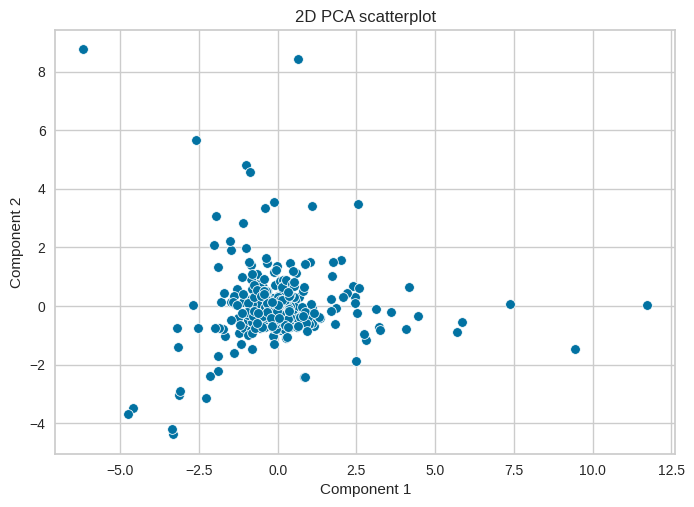

In [79]:
sns.scatterplot(data=reduced_df_pca, x='Component 1', y='Component 2')
plt.title('2D PCA scatterplot');


* We can identify one central cluster with three distinct 'rays' extending towards the north, southwest, and east. 
* There are also a few outlier points. 
* Next, we will color the scatter plot according to K-Means and Hierarchical Clustering labels.

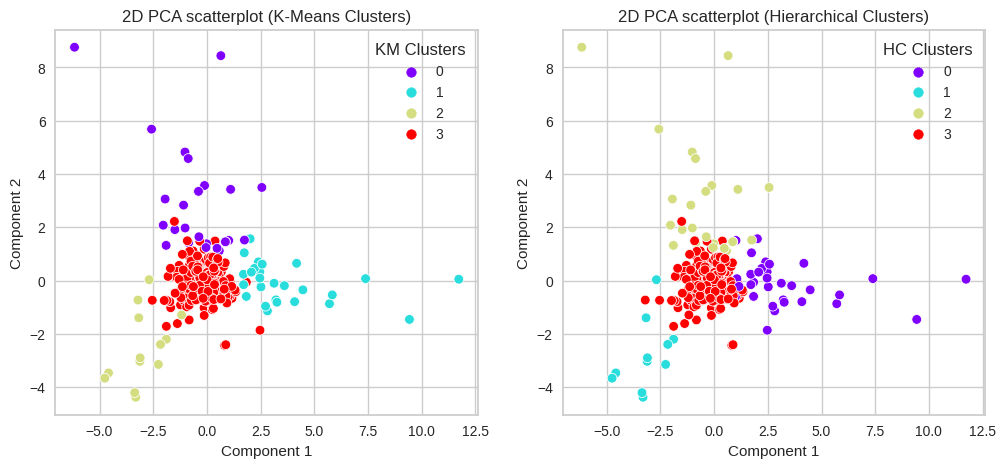

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(
    data=reduced_df_pca,
    x='Component 1',
    y='Component 2',
    hue=df['KM Clusters'],
    palette='rainbow',
    ax=axs[0],
    );
sns.scatterplot(
    data=reduced_df_pca,
    x='Component 1',
    y='Component 2',
    hue=df['HC Clusters'],
    palette='rainbow',
    ax=axs[1],
    )

axs[0].set_title('2D PCA scatterplot (K-Means Clusters)');
axs[1].set_title('2D PCA scatterplot (Hierarchical Clusters)');
plt.show();

**Observations:**
* The four clusters exhibit distinct separation, with one central cluster encompassing the majority of data points and the remaining clusters accounting for more peripheral points.
* Despite subtle differences in the plots generated by K-Means and Hierarchical Clustering, the prevailing structures of the clusters demonstrate more similarities than disparities.

### Applying t-SNE technique

In the following lines of code, we will project the 11-dimensional data into two dimensions using t-SNE.

In [81]:
# Setting the number of components to 2
tsne = TSNE(n_components=2, perplexity=30, random_state=42)

In [82]:
# Transforming data and storing results in a dataframe
X_reduced_tsne = tsne.fit_transform(subset_scaled_df.drop(['KM Clusters', 'HC Clusters'], axis=1))
reduced_df_tsne = pd.DataFrame(data=X_reduced_tsne, columns = ['Component 1', 'Component 2'])

In [83]:
reduced_df_tsne.tail()

Component 1  Component 2
335     9.258495     7.930939
336   -12.522353   -11.091595
337    11.285179    12.380670
338     0.686478     1.308196
339     1.213665     7.998796

**Let's visualize the reduced data to examine the degree of separation between the clusters.**

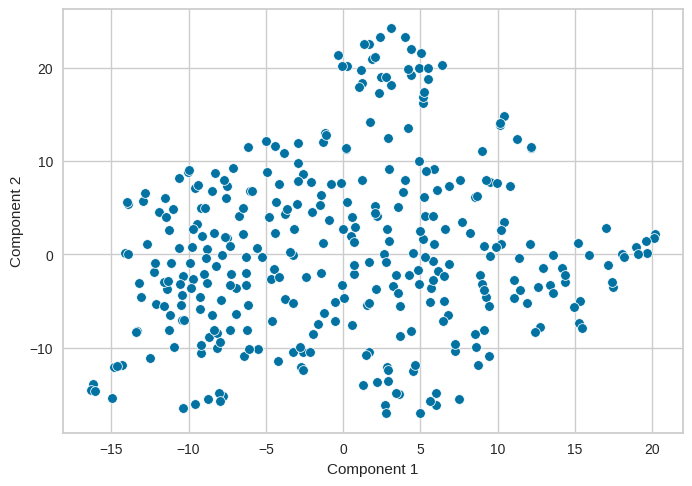

In [84]:
sns.scatterplot(data=reduced_df_tsne, x='Component 1', y='Component 2');

* Using the default settings of t-SNE, the data points have been distributed uniformly.
* Visually discerning distinct clusters is challenging.
* However, let us color the scatter plot according to K-Means and Hierarchical Clustering labels.

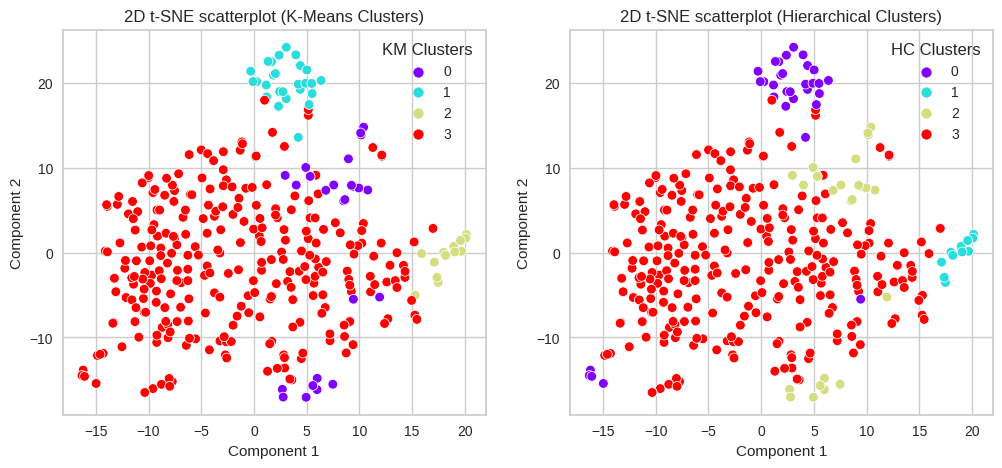

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(
    data=reduced_df_tsne,
    x='Component 1',
    y='Component 2',
    hue=df['KM Clusters'],
    palette='rainbow',
    ax=axs[0],
    );
sns.scatterplot(
    data=reduced_df_tsne,
    x='Component 1',
    y='Component 2',
    hue=df['HC Clusters'],
    palette='rainbow',
    ax=axs[1],
    )

axs[0].set_title('2D t-SNE scatterplot (K-Means Clusters)');
axs[1].set_title('2D t-SNE scatterplot (Hierarchical Clusters)');
plt.show();

## Actionable Insights and Recommendations

**Cluster «Energy»$^1$: 1-KM / 0-HC:**
* Highest risk
* Top-3 by Net Income: Hewlett Packard Enterprise, Quanta Services Inc., Kinder Morgan
* Around 8%-9% of the securities presented in the dataset belong to this cluster, with the majority of them representing companies from the Energy sector.
* This cluster carries high risk due to negative net income and earnings per share. The P/E ratio is relatively high, suggesting an overvalued stock. The high volatility and exceptionally high ROE further contribute to the risk profile.
* Exercise caution when considering investments from this cluster. It's crucial to conduct a thorough analysis of the underlying reasons for the negative financials and evaluate the company's prospects. Consider diversifying investments across other clusters with stronger financial performance.

**Cluster «Industrials»: 3-KM / 3-HC:**
* High risk
* Top-3 by Net Income: International Business Machines, General Motors, The Walt Disney Company
* Around 80% of the securities presented in the dataset belong to this cluster, with the majority of them representing companies from the Industrials sector. However, it should be noted that this cluster exhibits a good level of diversification.
* This cluster carries a moderate to high risk level. The P/E and P/B ratios suggest undervaluation, and the volatility is relatively low. However, the negative net cash flow raises concerns.
* Exercise caution when considering investments from this cluster. Further investigation is required to understand the reasons for the negative net cash flow and to assess the company's ability to generate positive cash flow in the future. It may be prudent to diversify investments across other clusters with more favorable financial indicators.

**Cluster «Health Care»: 0-KM / 2-HC:**
* Moderate risk
* Top-3 by Net Income: Amgen Inc., McDonald's Corp., Facebook
* Around 7% of the securities presented in the dataset belong to this cluster, with the majority of them representing companies from the Health Care sector.
* This cluster appears to have moderate risk with relatively high valuations and moderate volatility. The company seems to have a healthy cash position and positive net cash flow.
* Consider maintaining a balanced portfolio by including stocks from this cluster. Due to the moderate risk level, it may be advisable to conduct further analysis on individual stocks within this cluster to identify specific investment opportunities.
  
**Cluster «Financials»: 2-KM / 1-HC:**
* Moderate risk
* Top-3 by Net Income: JPMorgan Chase & Co., Wells Fargo, Verizon Communications
* Around 3%-4% of the securities presented in the dataset belong to this cluster, with the majority of them representing companies from the Financials sector.
* This cluster has moderate risk, with moderate valuations and relatively low volatility. The cash ratio and net cash flow are favorable, indicating a healthy cash position and positive cash flow.
* Consider this cluster as a potential investment opportunity. Further analysis of individual stocks within this cluster is recommended to identify companies with strong fundamentals and growth potential. Diversifying investments by including stocks from this cluster may provide a balanced risk exposure.

---
$^1$ *While the names of the clusters do reflect the sector most prominently represented within them, it's important to understand that these labels are provisional. They serve the purpose of simplifying notation and should not be taken as a comprehensive characterization of the entire sector they represent.*


**Investment Strategy Variety.** The four clusters identified represent a broad range of company profiles, each with different investment implications. Some are better suited to conservative investment strategies, some to growth-oriented strategies, and others represent more speculative or risky bets.

**Risk and Reward Trade-off.** As typically found in investment scenarios, higher potential reward (in terms of stock price growth or profitability) often comes with higher risk (as indicated by volatility and negative financial indicators like Net Cash Flow and P/B Ratio).

**Financial Health Assessment.** Financial indicators such as ROE, Cash Ratio, Net Cash Flow, Net Income, P/E Ratio, and P/B Ratio are crucial to assess the financial health of a company. Clusters with companies showing negative values in these parameters are generally riskier.

**Sector Insights.** Although not directly clustered based on sectors, it would be interesting to study the sector-wise distribution of companies in these clusters. Such analysis can provide additional insights into sector-specific trends.
  * The `Current Price` of stocks and `Estimated Shares Outstanding` demonstrate a right-skewed distribution, with `Health Care` and `Financial` sectors showing notable positive `Price Change`, making them appealing to investors.

  * The `Information Technology` and `Financial` sectors possess high `Cash Ratio`, indicating favorable liquidity. Conversely, the `Real Estate` sector, with its minimal variance in `Price Change` and `Cash Ratio`, represents a more stable investment opportunity.

  * The `Energy` sector, although exhibiting high `Price Change` variance and therefore increased risk, attracts investment due to its high `P/E_Ratio`, implying investor willingness to pay more per share relative to earnings.


The clustering analysis offer a nuanced and diversified approach to investing, which aligns well with best practices in portfolio management.

* **Diversification across investment types.** The identification of different clusters - very aggressive (high & low performing), moderately aggressive (high performing), and mildly aggressive options - provides a valuable foundation for building diversified investment portfolios. Diversification is a key strategy in portfolio management, aimed at balancing risk and return by investing in different types of securities.

* **Market Volatility and the need for dynamic clustering.** Our insights from the exploratory data analysis (EDA) and clustering emphasize the fact that stock markets are indeed volatile. As we've identified, sectors like Energy can be more volatile and riskier for investors. This can help in identifying shifting trends and volatility in different sectors, and thus make better predictions for future investments.

* **Past performance and future trends.** Past indicators may not always predict future trends. While the analysis provides a good understanding of historical performance, future performance can be influenced by a wide range of factors, including changing market conditions, industry trends, and global economic factors. Therefore, continuous monitoring and updating of investment strategies, as well as being aware of broader market and economic trends, are key for successful investing.

Overall, our clustering analysis not only provides valuable insights into the current state of the stock market but also highlights the importance of continual analysis and adjustment in response to evolving market conditions.

*The analysis provides a starting point for diversifying investments across different types of stocks. However, each investor's personal situation, risk tolerance, and investment goals should be considered when making investment decisions. Also, the investment landscape is dynamic. Regular reviews and updates to the investment strategy are necessary to adapt to changes in the market conditions and in the specific circumstances of each company.*

In [86]:
%%shell
jupyter nbconvert --to html /content/project_7_at.ipynb